In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor
import utils as u
from sklearn.metrics import classification_report
import joblib

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


## Loading meme data

In [2]:
gaming = pd.read_csv('../data/processed/gaming.csv')
ai = pd.read_csv('../data/processed/ai.csv')
meme = pd.read_csv('../data/processed/meme.csv')
rwa = pd.read_csv('../data/processed/rwa.csv')

gaming.shape, ai.shape, meme.shape, rwa.shape

((126980, 10), (114410, 10), (33454, 10), (52833, 10))

## Preprocessing data

In [3]:
days_to_predict = 7

In [4]:
class category_data:
    def __init__(self, train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler):
        self.train_data = train_data
        self.series_dict = series_dict
        self.exog_dict = exog_dict
        self.future_exog_dict = future_exog_dict
        self.series_scaler = series_scaler
        self.exog_scaler = exog_scaler
        self.forecaster = None
        self.predictions = None
        self.og_train = None
        self.og_pred = None
        self.error_df = None
        self.close_df = None

In [5]:
def generate_data_object(data: pd.DataFrame, days: int):
    train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler = u.preprocess_future(data, days_to_predict=days)
    data_obj = category_data(train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler)
    return data_obj

In [6]:
gaming_obj = generate_data_object(gaming, days_to_predict)
ai_obj = generate_data_object(ai, days_to_predict)
meme_obj = generate_data_object(meme, days_to_predict)
rwa_obj = generate_data_object(rwa, days_to_predict)

In [7]:
print(gaming_obj.train_data['id'].nunique())
print(ai_obj.train_data['id'].nunique())
print(meme_obj.train_data['id'].nunique())
print(rwa_obj.train_data['id'].nunique())

59
31
18
16


In [8]:
# gaming_obj.forecaster = u.train_best_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict, gaming_obj.future_exog_dict, gaming_obj.test_data, future_days=days_to_predict)
# ai_obj.forecaster = u.train_best_forecaster(ai_obj.series_dict, ai_obj.exog_dict, ai_obj.future_exog_dict, ai_obj.test_data, future_days=days_to_predict)
# meme_obj.forecaster = u.train_best_forecaster(meme_obj.series_dict, meme_obj.exog_dict, meme_obj.future_exog_dict, meme_obj.test_data, future_days=days_to_predict)
# rwa_obj.forecaster = u.train_best_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict, rwa_obj.future_exog_dict, rwa_obj.test_data, future_days=days_to_predict)

In [9]:
gaming_obj.forecaster = u.train_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict)
ai_obj.forecaster = u.train_forecaster(ai_obj.series_dict, ai_obj.exog_dict)
meme_obj.forecaster = u.train_forecaster(meme_obj.series_dict, meme_obj.exog_dict)
rwa_obj.forecaster = u.train_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict)

{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}


In [10]:
gaming_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=gaming_obj.forecaster, future_exog_dict=gaming_obj.future_exog_dict)
ai_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=ai_obj.forecaster, future_exog_dict=ai_obj.future_exog_dict)
meme_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=meme_obj.forecaster, future_exog_dict=meme_obj.future_exog_dict)
rwa_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=rwa_obj.forecaster, future_exog_dict=rwa_obj.future_exog_dict)

In [11]:
gaming_obj.og_train, gaming_obj.og_pred = u.inverse_scaling_future(train_df=gaming_obj.train_data, pred_df=gaming_obj.predictions, scalers=gaming_obj.series_scaler)
ai_obj.og_train, ai_obj.og_pred = u.inverse_scaling_future(train_df=ai_obj.train_data, pred_df=ai_obj.predictions, scalers=ai_obj.series_scaler)
meme_obj.og_train, meme_obj.og_pred = u.inverse_scaling_future(train_df=meme_obj.train_data, pred_df=meme_obj.predictions, scalers=meme_obj.series_scaler)
rwa_obj.og_train, rwa_obj.og_pred = u.inverse_scaling_future(train_df=rwa_obj.train_data, pred_df=rwa_obj.predictions, scalers=rwa_obj.series_scaler)

In [12]:
gaming_obj.og_pred

06963e10-2042-41d3-9583-acb4135460dc  \
2024-10-29                              0.002072   
2024-10-30                              0.002079   
2024-10-31                              0.001828   
2024-11-01                              0.001858   
2024-11-02                              0.001800   
2024-11-03                              0.001945   
2024-11-04                              0.001860   

            0844705f-10ed-42ca-b483-914b7d59e351  \
2024-10-29                              0.286093   
2024-10-30                              0.279201   
2024-10-31                              0.270842   
2024-11-01                              0.275289   
2024-11-02                              0.280168   
2024-11-03                              0.282351   
2024-11-04                              0.282591   

            10e910bd-6f50-4085-bd78-fbbcde408d28  \
2024-10-29                              0.052678   
2024-10-30                              0.053525   
2024-10-31                              0.052247   
2024-11-01                              0.055312   
2024-11-02                              0.054905   
2024-11-03                              0.055898   
2024-11-04                              0.056440   

            1ae14641-7365-4be1-9bb9-c86ab07715b3  \
2024-10-29                              1.208923   
2024-10-30                              1.194811   
2024-10-31                              1.154768   
2024-11-01                              1.142101   
2024-11-02                              1.158111   
2024-11-03                              1.163401   
2024-11-04                              1.167165   

            2150225f-b2f2-4b59-bc68-001aa8ae4666  \
2024-10-29                              0.034983   
2024-10-30                              0.036109   
2024-10-31                              0.030230   
2024-11-01                              0.034554   
2024-11-02                              0.028787   
2024-11-03                              0.030257   
2024-11-04                              0.027147   

            246715d6-065f-475e-8026-3e0a201c7e33  \
2024-10-29                             -0.000033   
2024-10-30                             -0.000205   
2024-10-31                             -0.000460   
2024-11-01                             -0.000044   
2024-11-02                              0.000133   
2024-11-03                              0.000243   
2024-11-04                              0.000209   

            24e85250-c2a7-4158-8e7d-244818085463  \
2024-10-29                              0.026132   
2024-10-30                              0.030797   
2024-10-31                              0.033241   
2024-11-01                              0.045496   
2024-11-02                              0.047643   
2024-11-03                              0.054267   
2024-11-04                              0.053313   

            30d41b9d-f8eb-4821-8a6e-9016bfd35023  \
2024-10-29                             -0.011546   
2024-10-30                             -0.010943   
2024-10-31                             -0.011381   
2024-11-01                             -0.005883   
2024-11-02                             -0.003912   
2024-11-03                             -0.002309   
2024-11-04                             -0.007480   

            39268841-e3d8-40b3-8c30-6d6d5bb19bf4  \
2024-10-29                              0.139156   
2024-10-30                              0.137396   
2024-10-31                              0.136580   
2024-11-01                              0.141981   
2024-11-02                              0.145696   
2024-11-03                              0.144308   
2024-11-04                              0.142592   

            3a048f18-7aab-4abf-87bd-9f70572c5a9e  ...  \
2024-10-29                              0.003773  ...   
2024-10-30                              0.003741  ...   
2024-10-31                              0.003712  ...   
2024-11-01                     

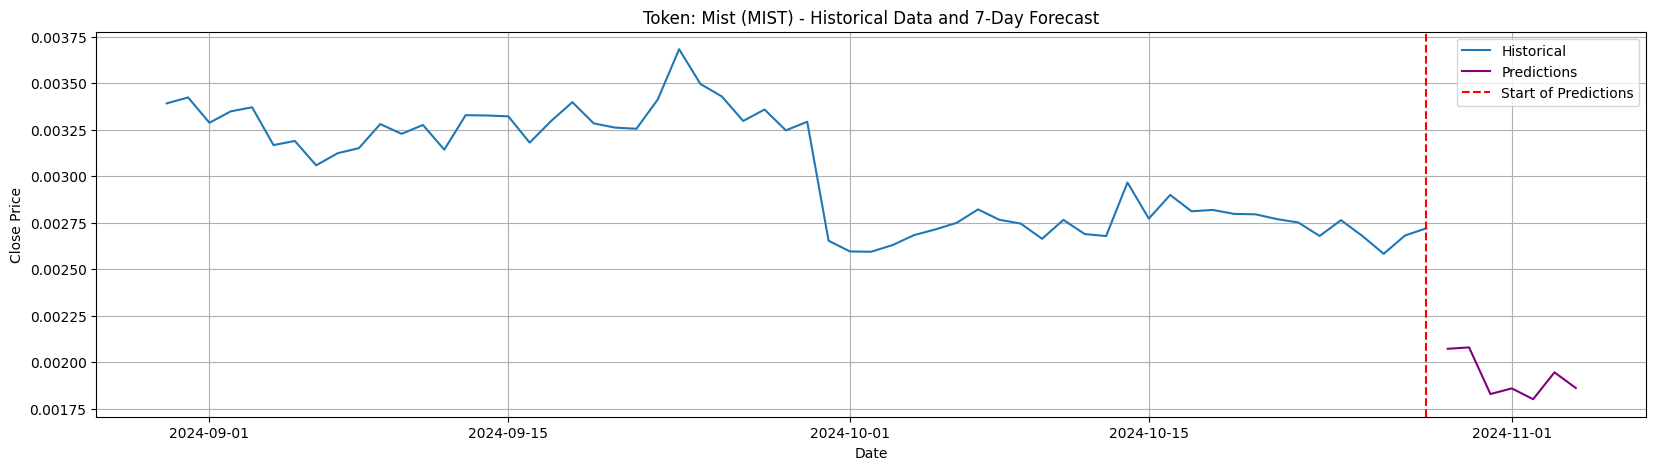

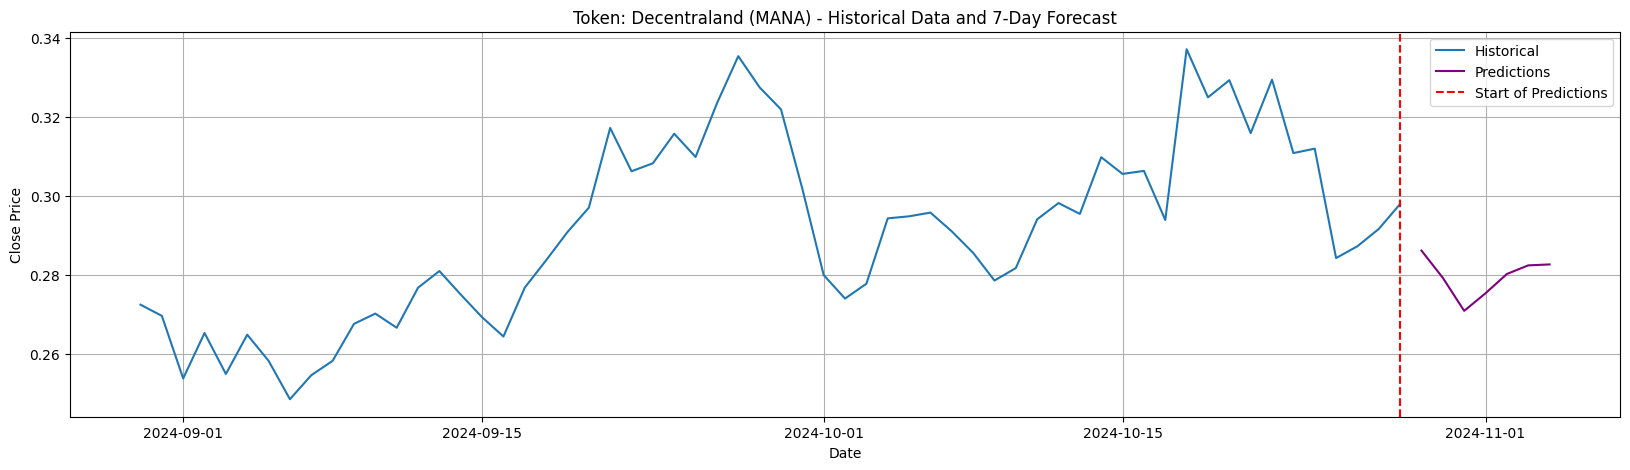

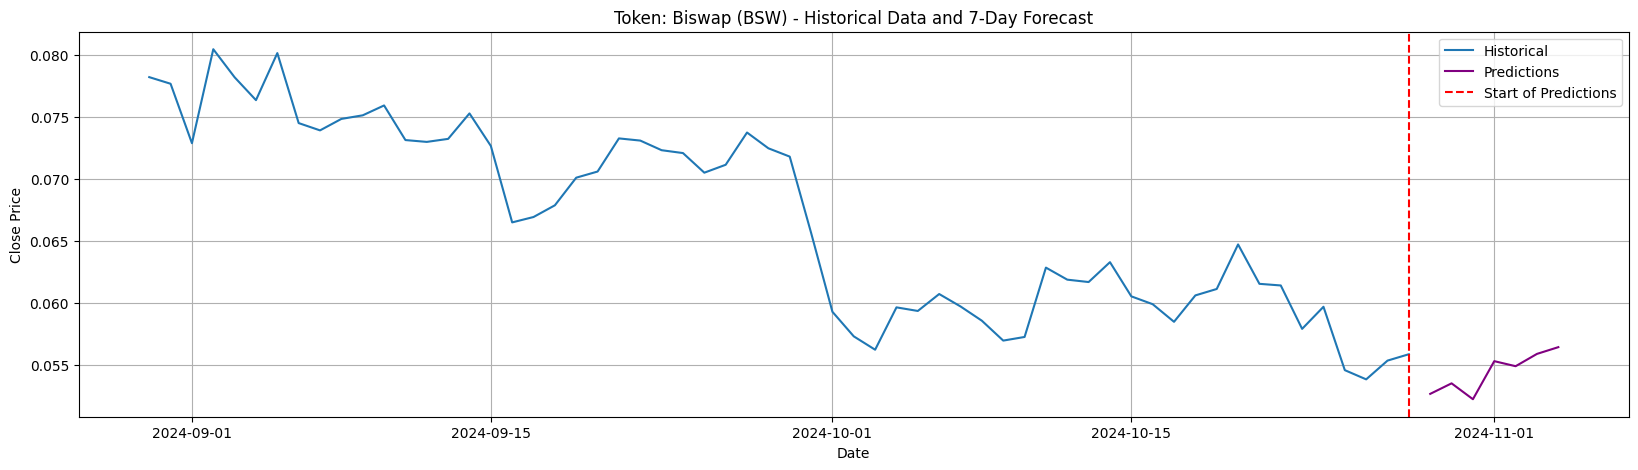

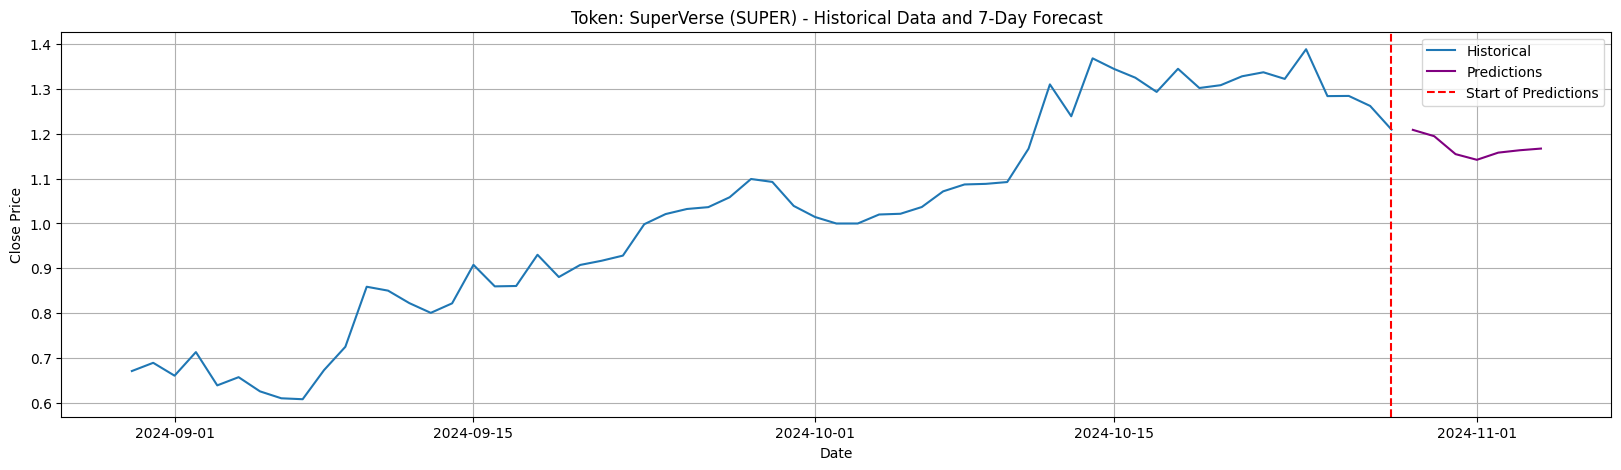

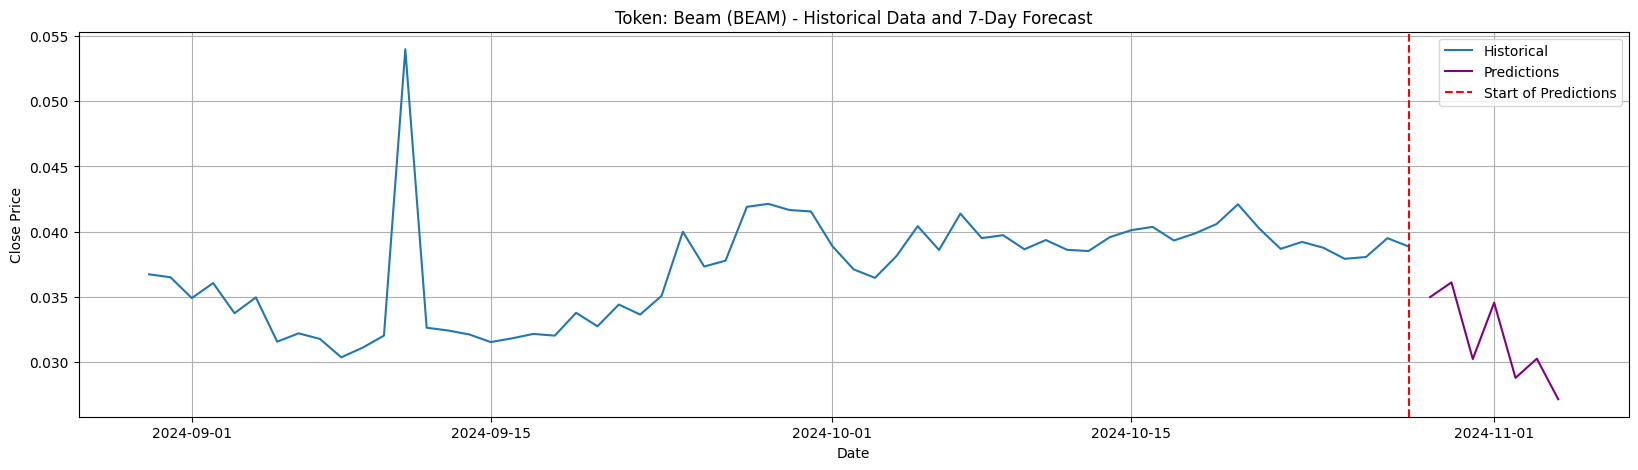

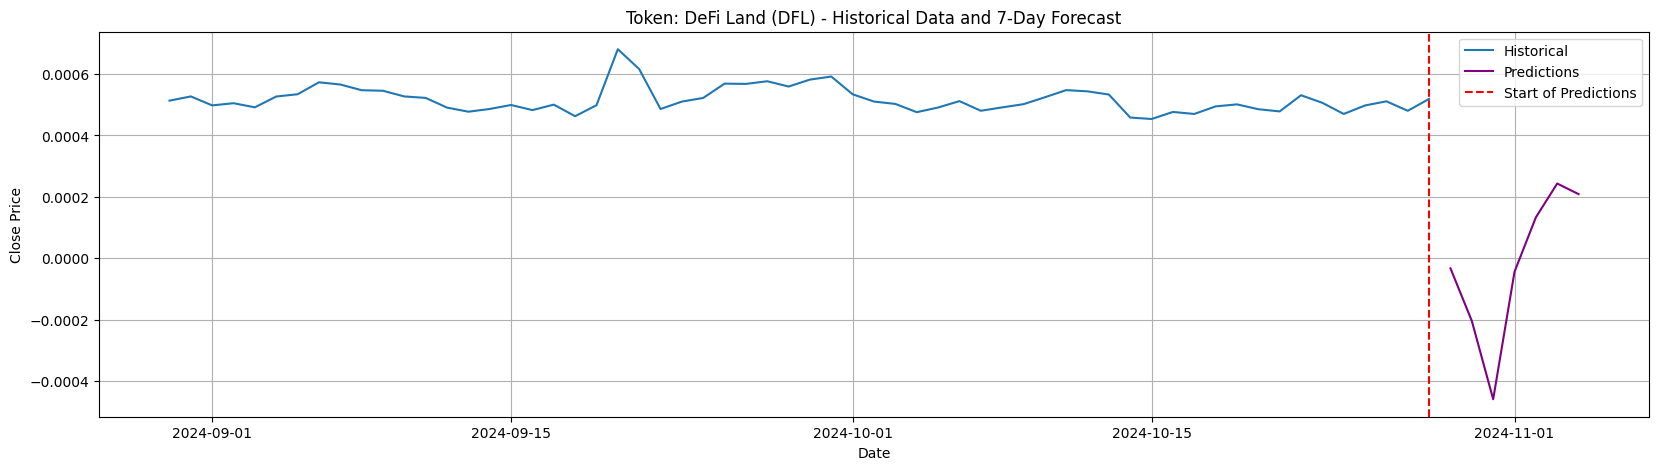

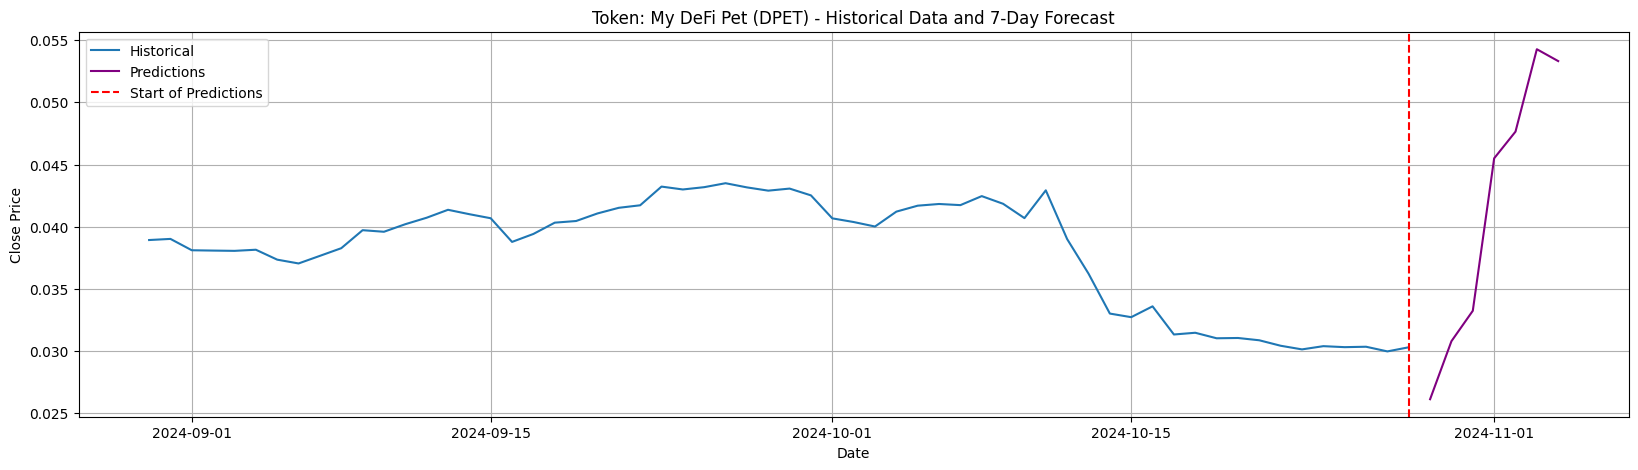

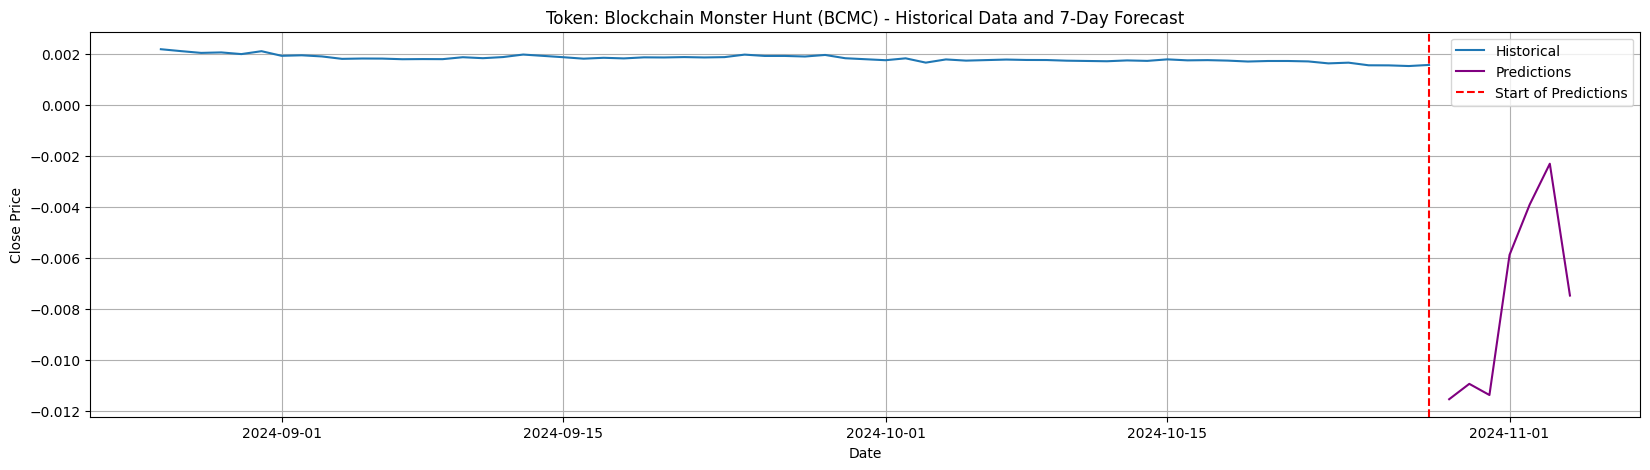

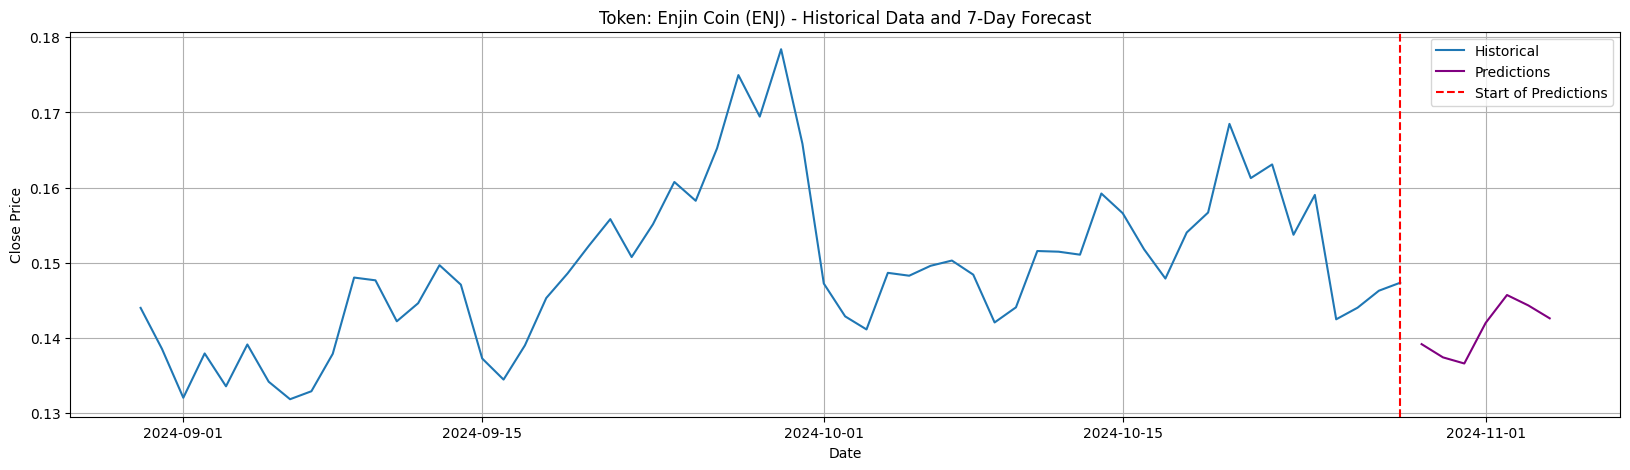

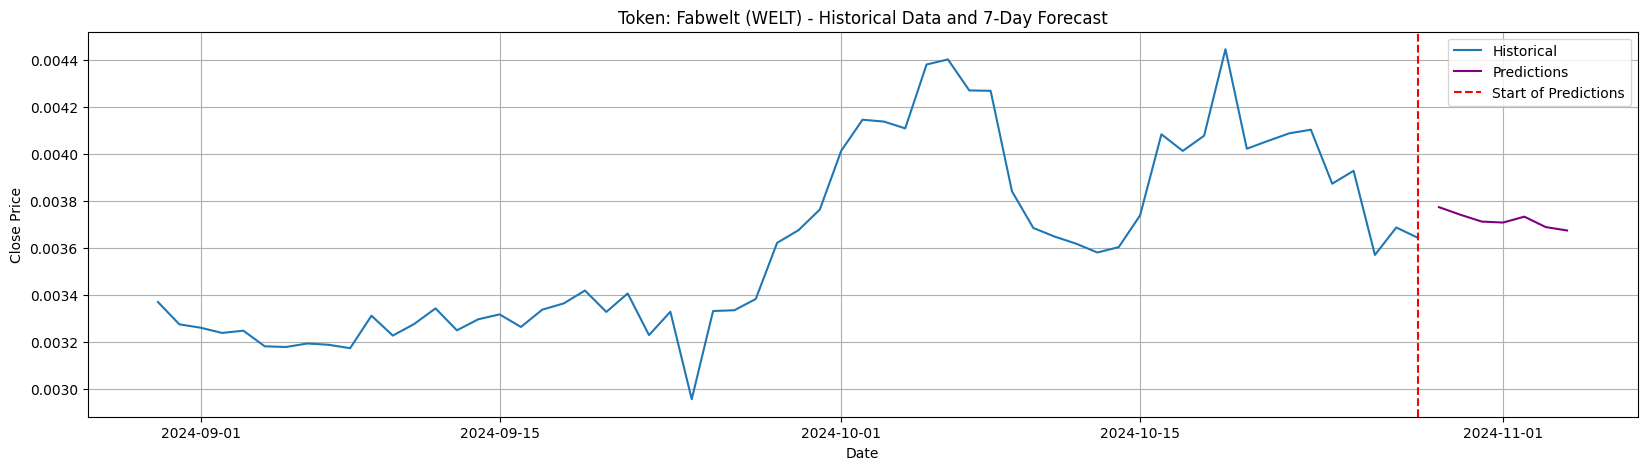

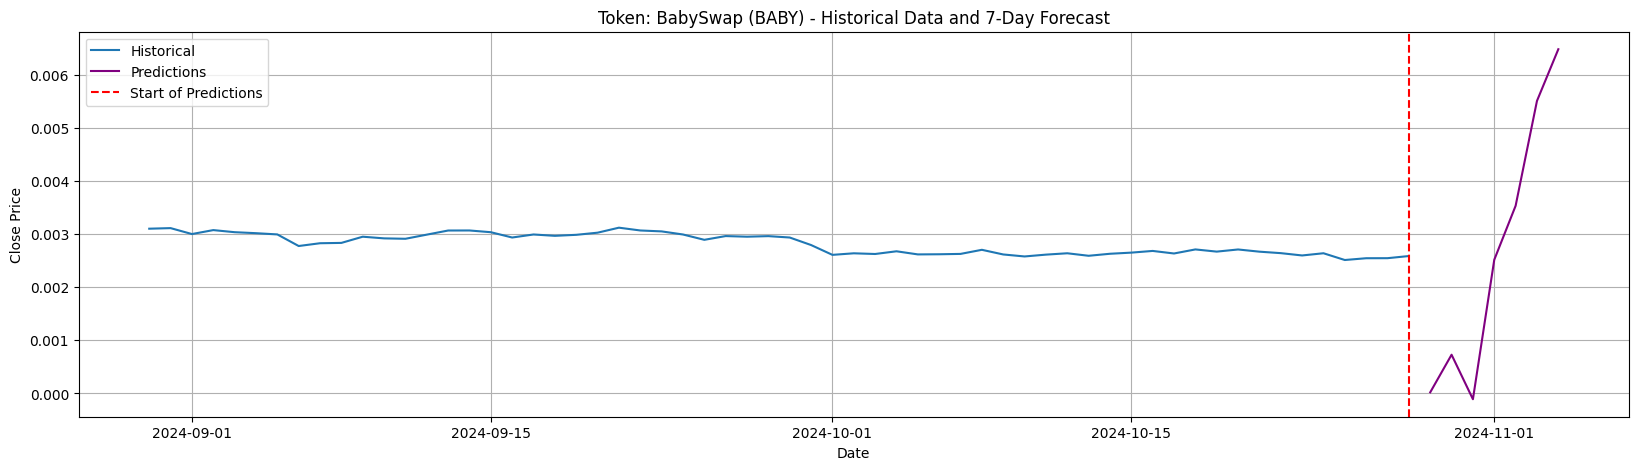

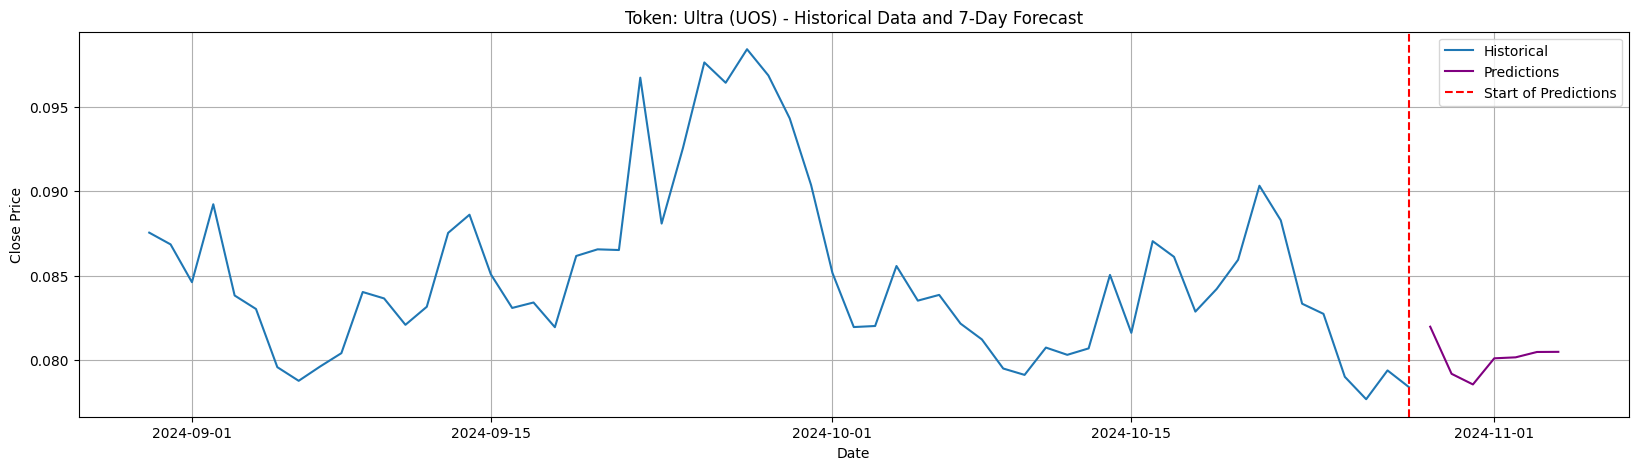

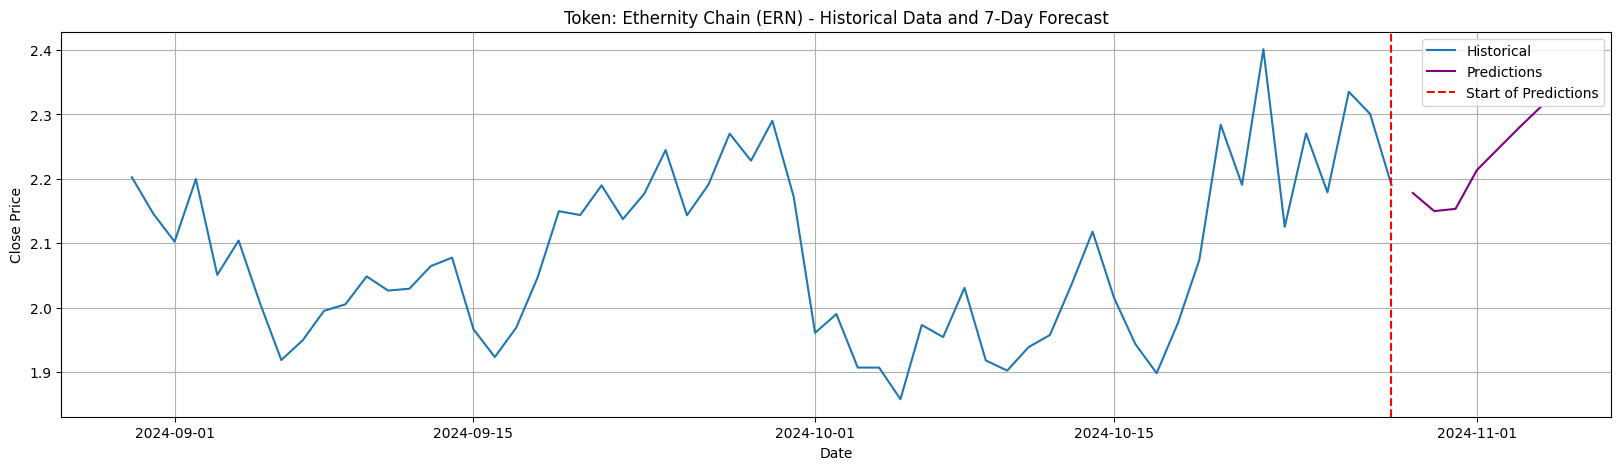

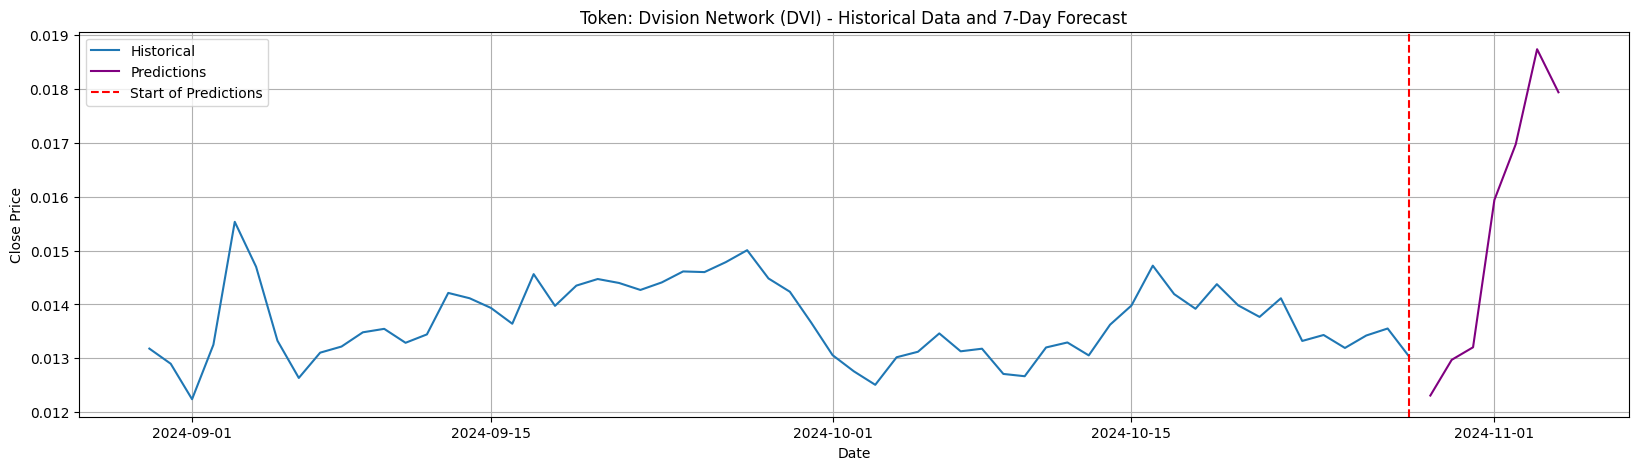

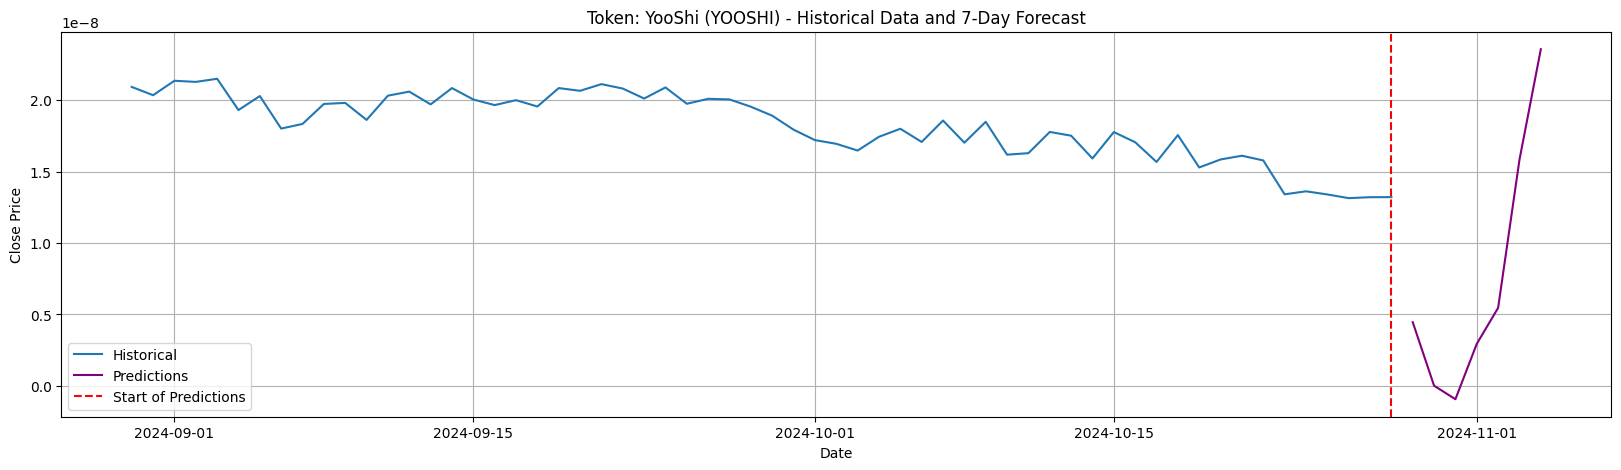

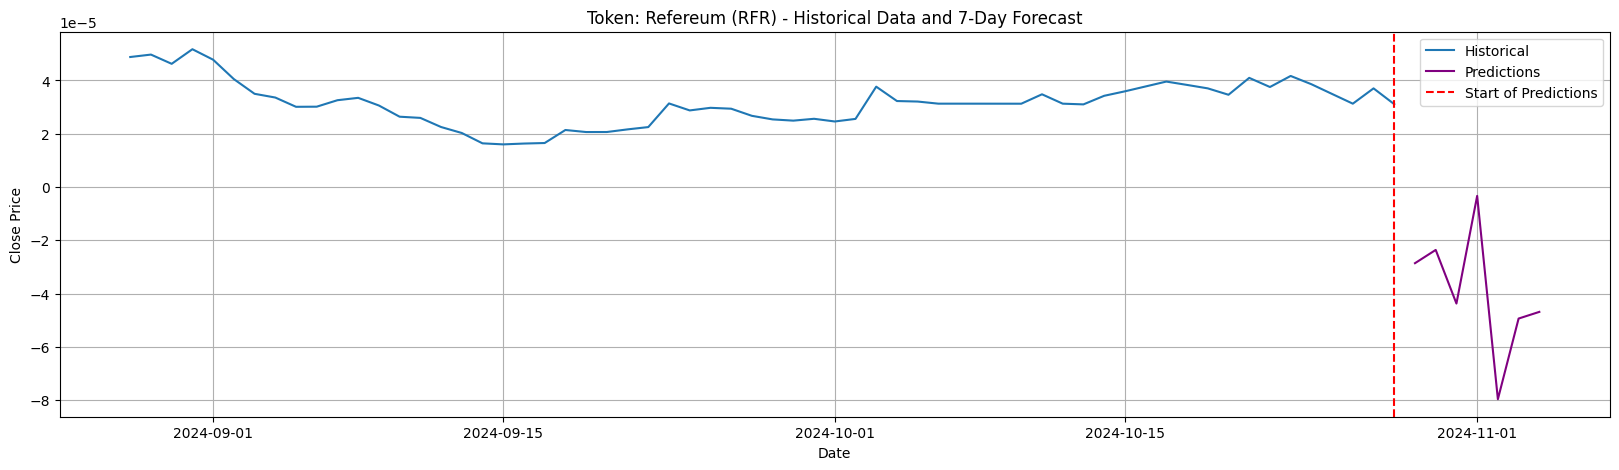

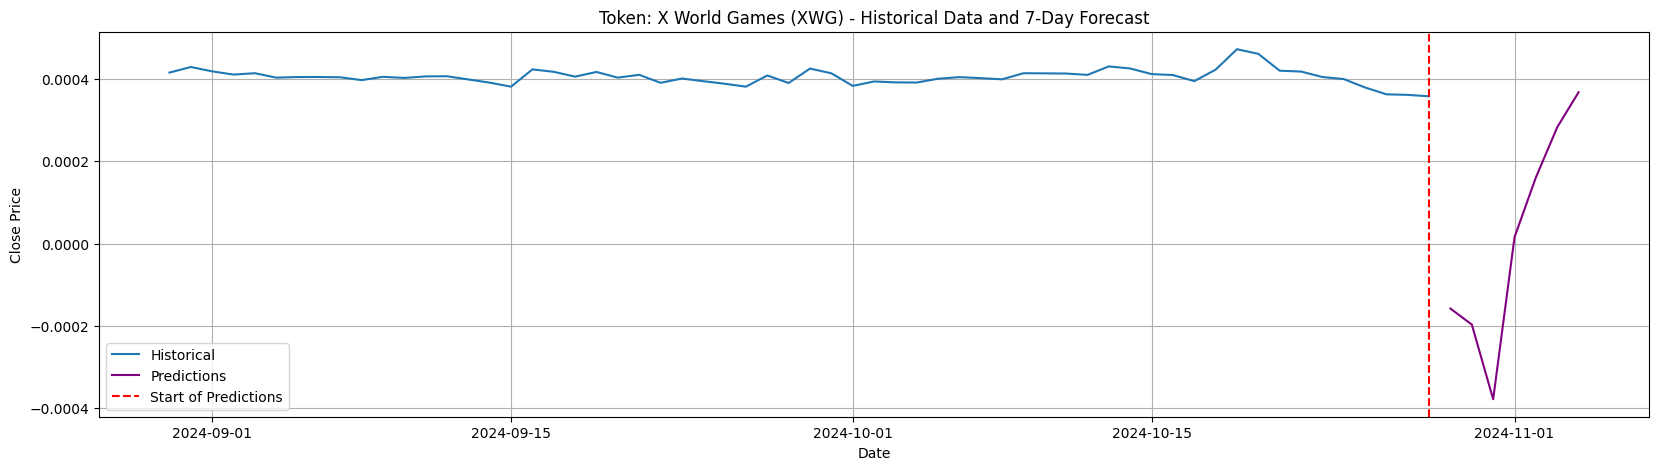

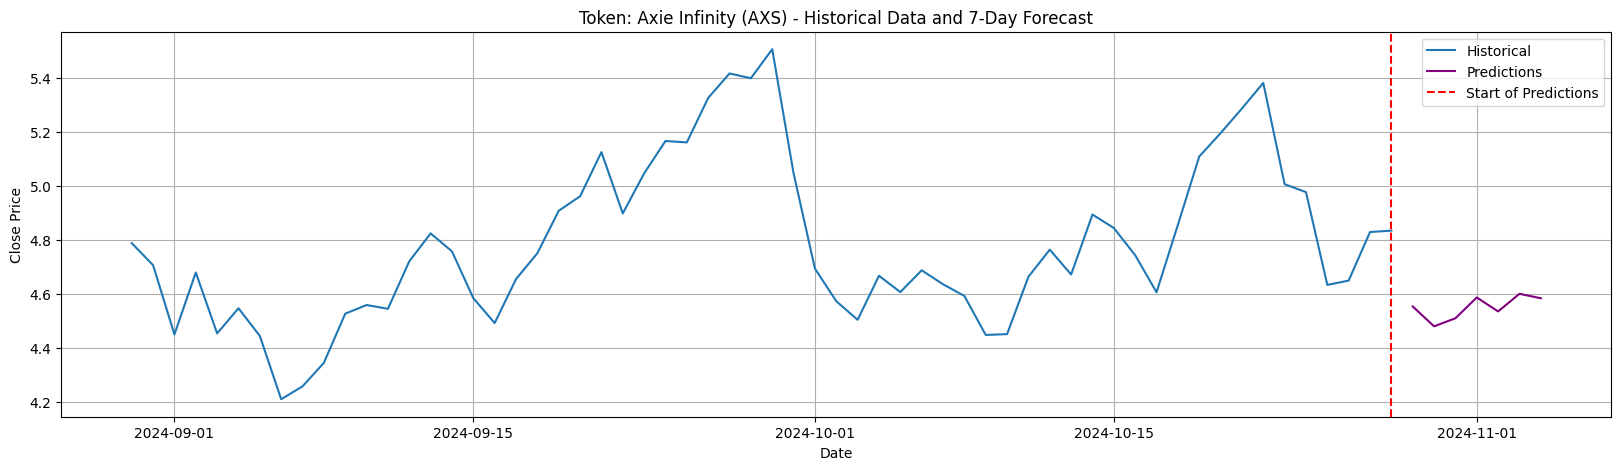

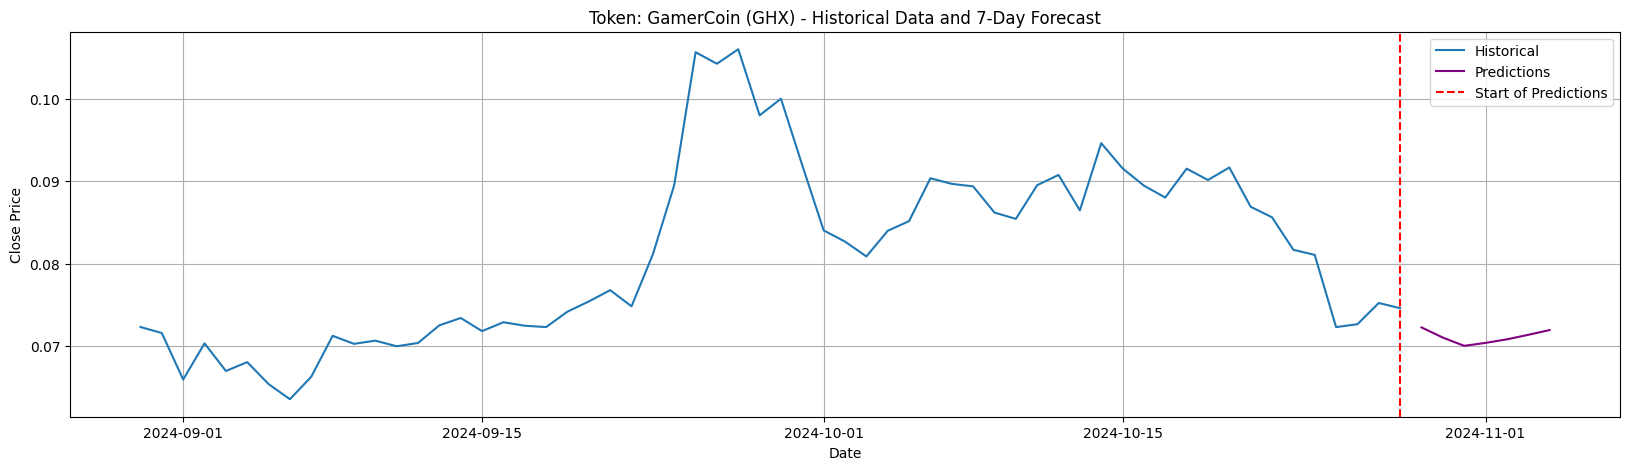

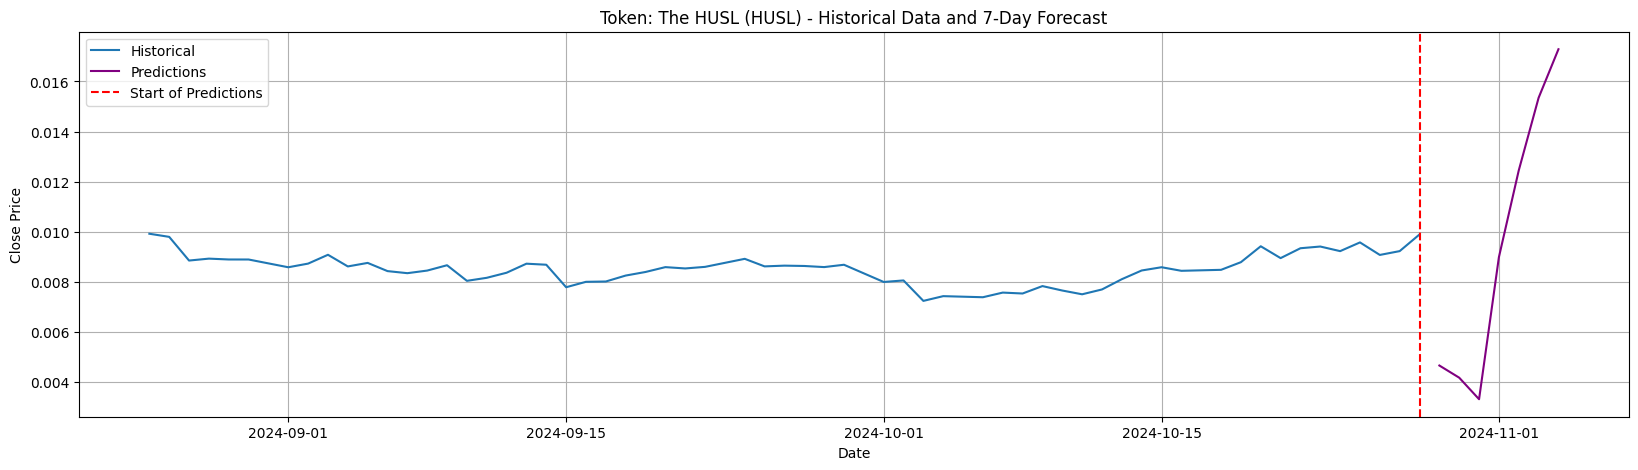

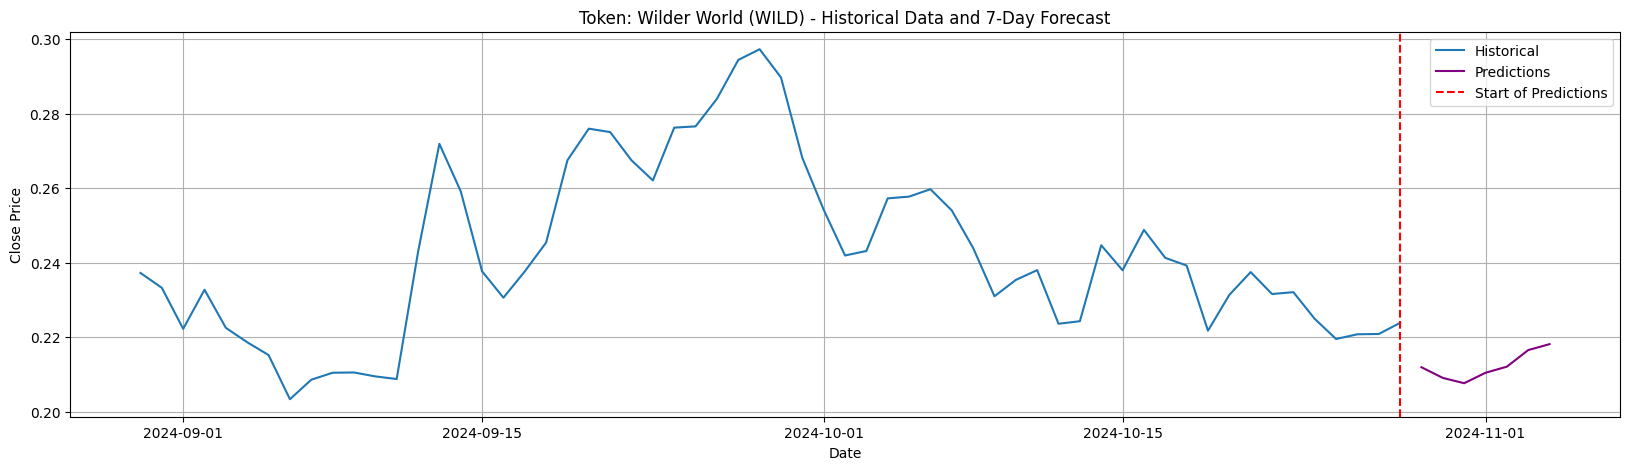

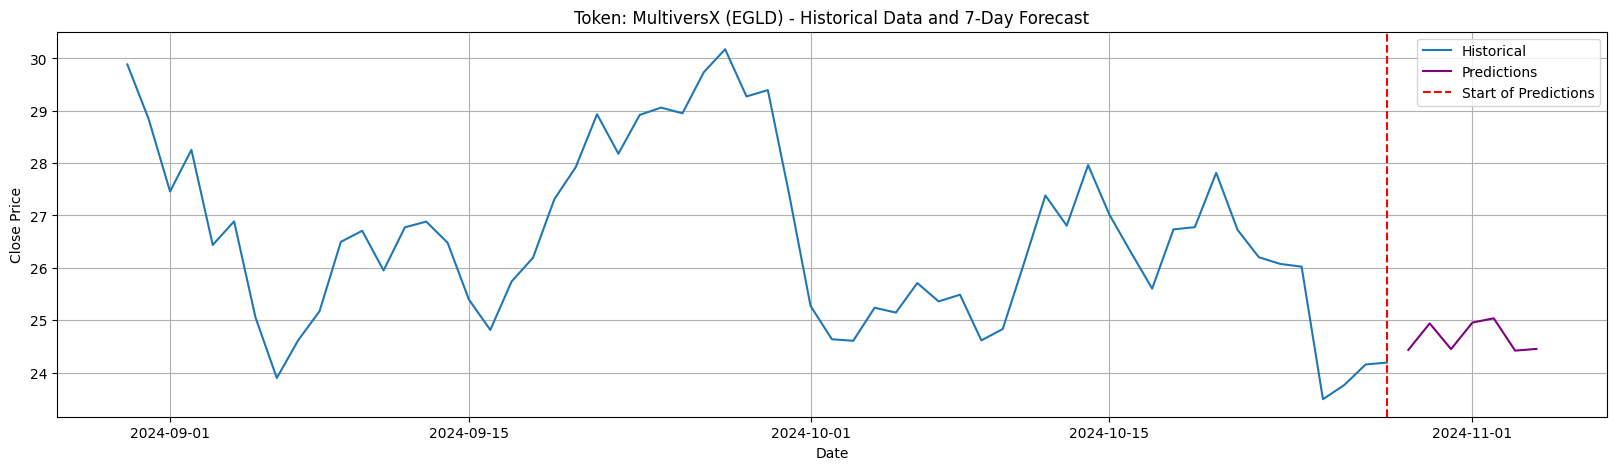

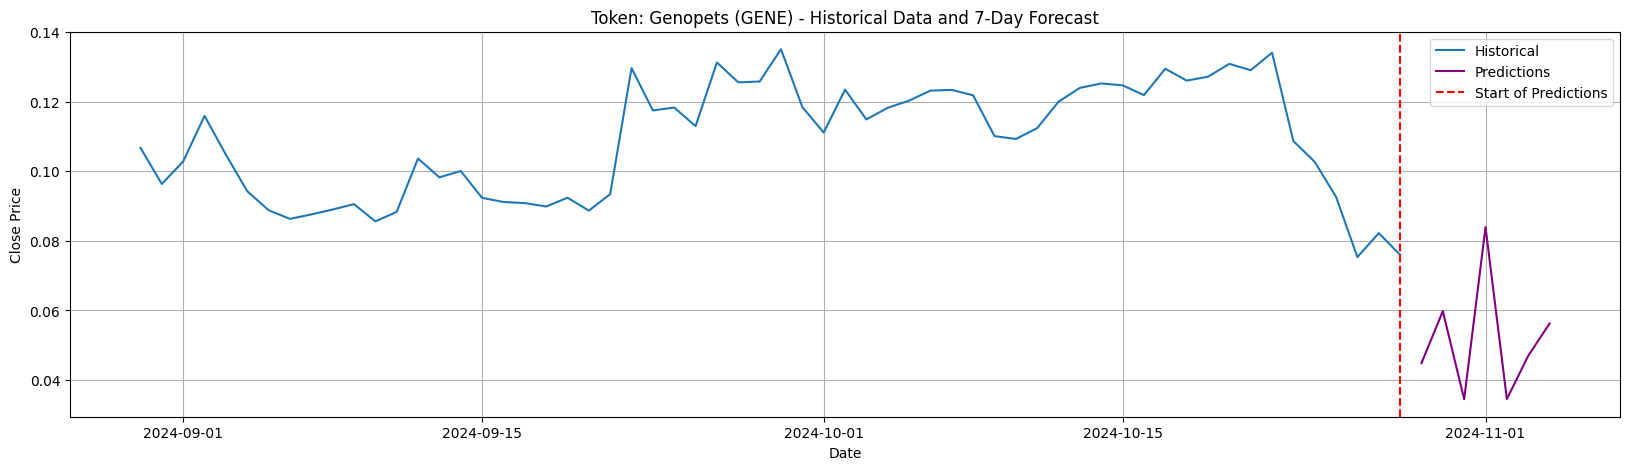

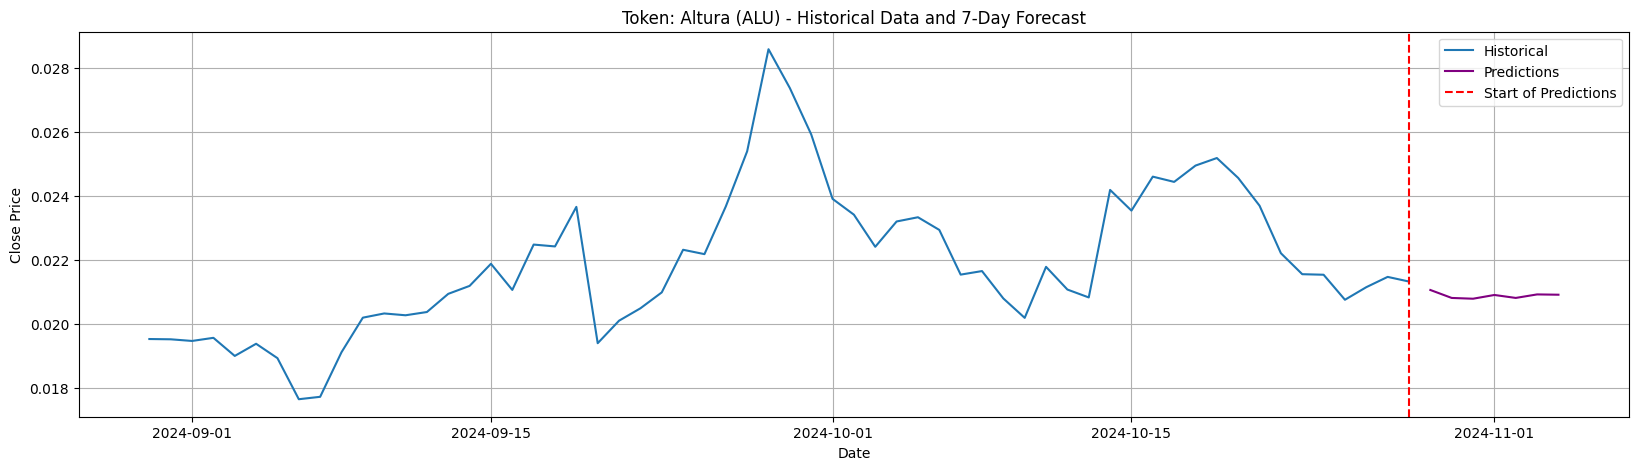

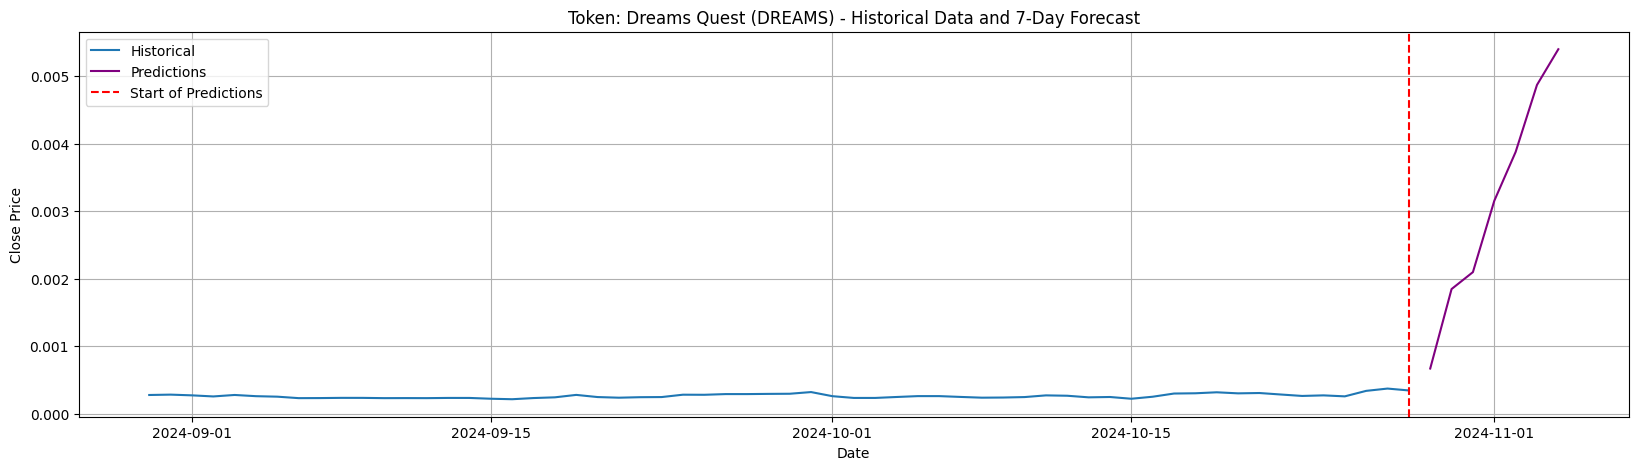

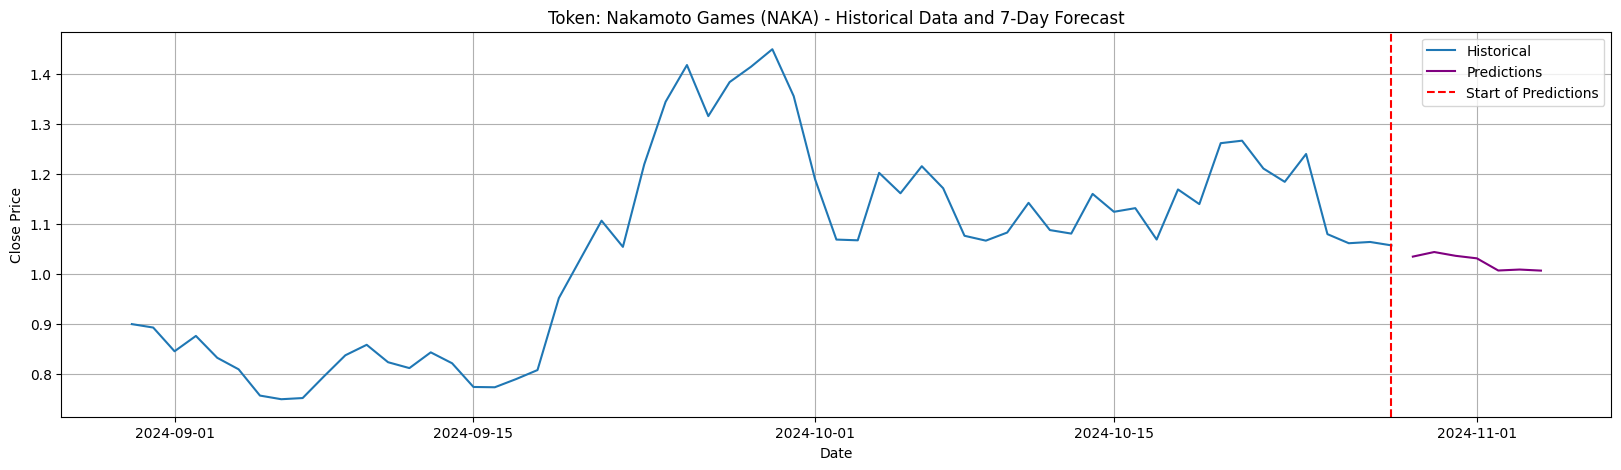

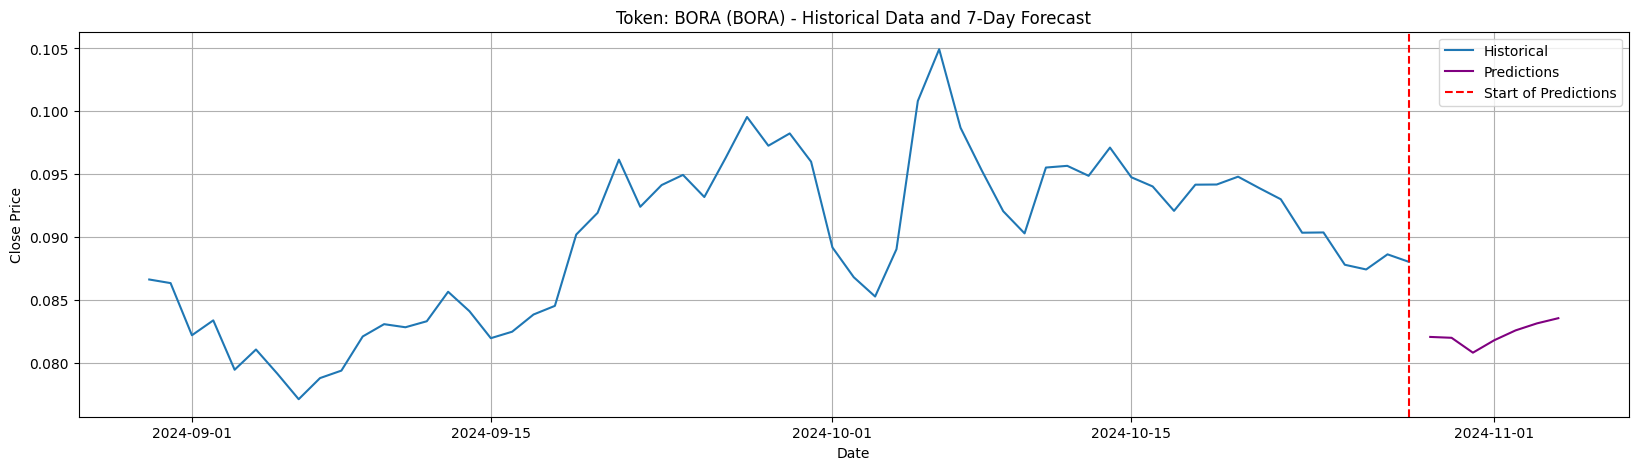

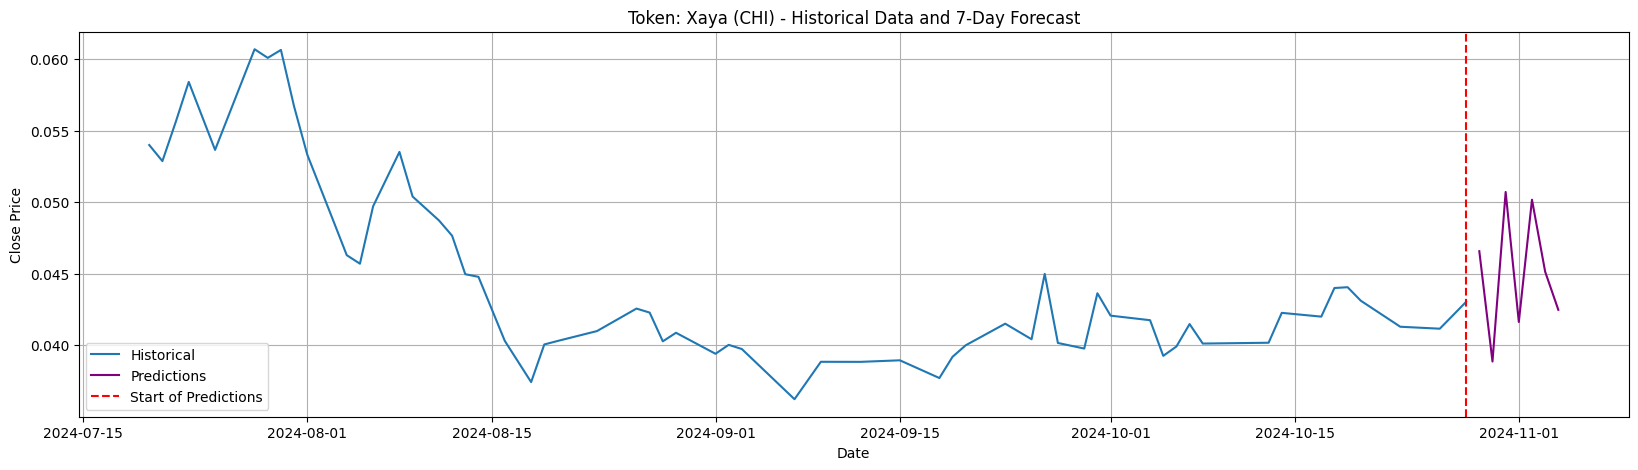

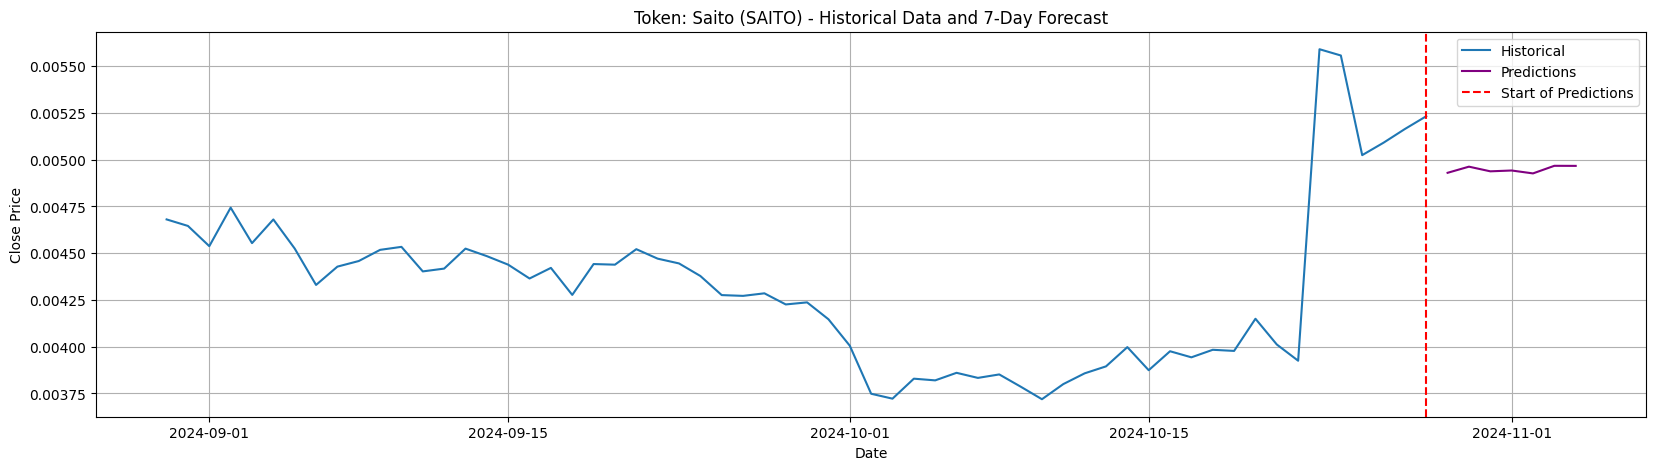

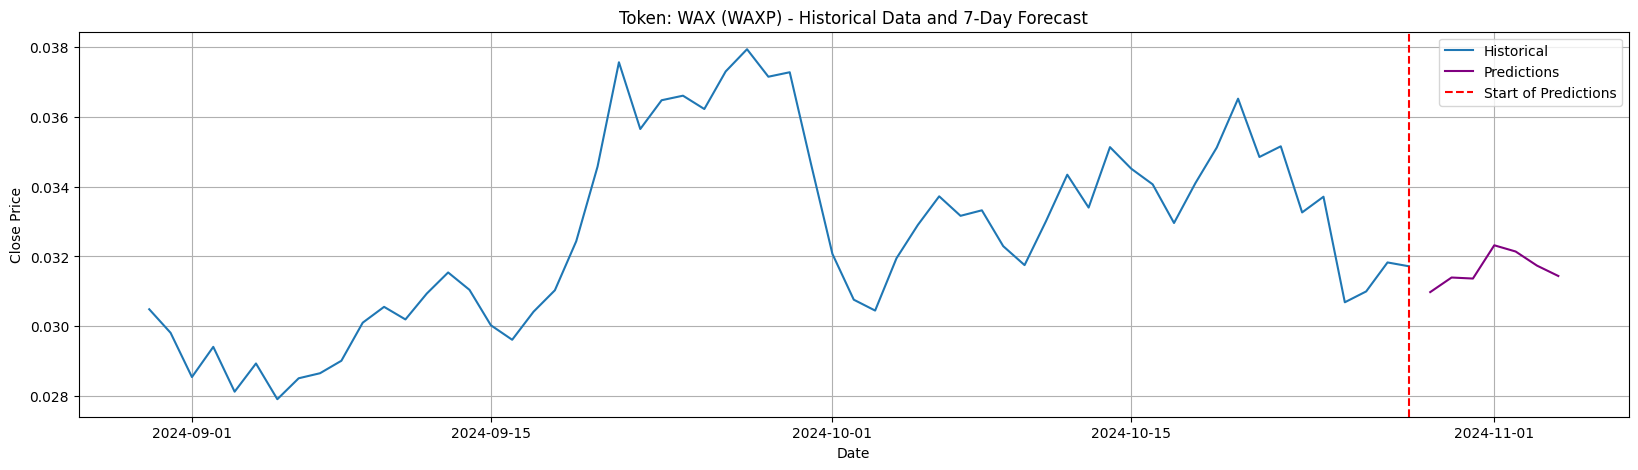

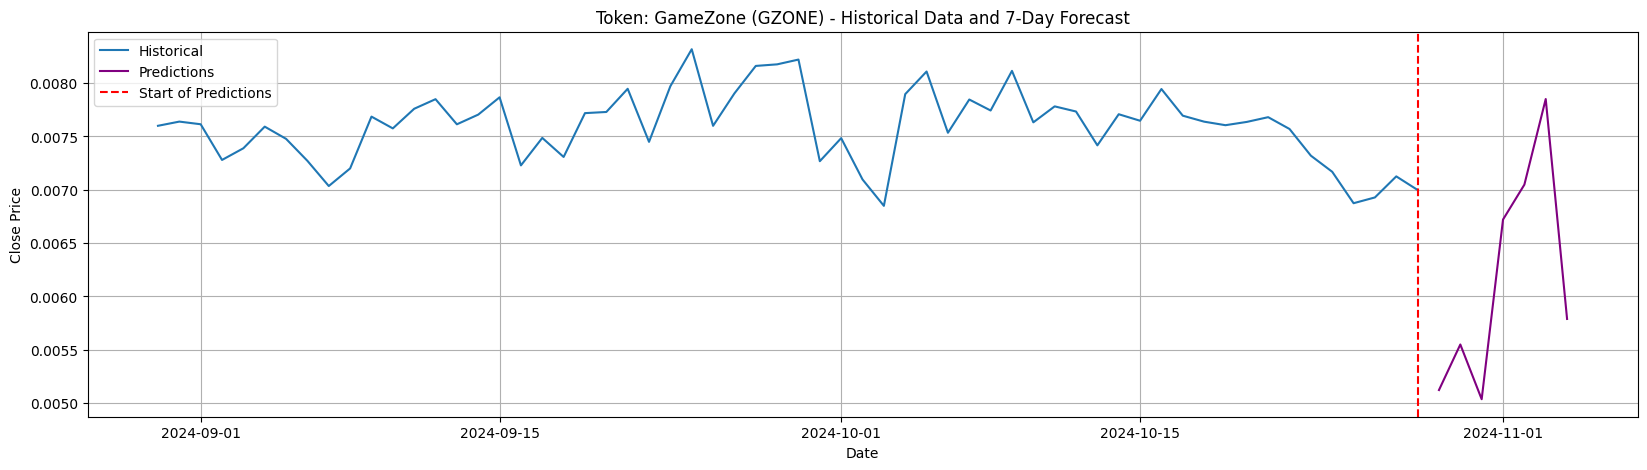

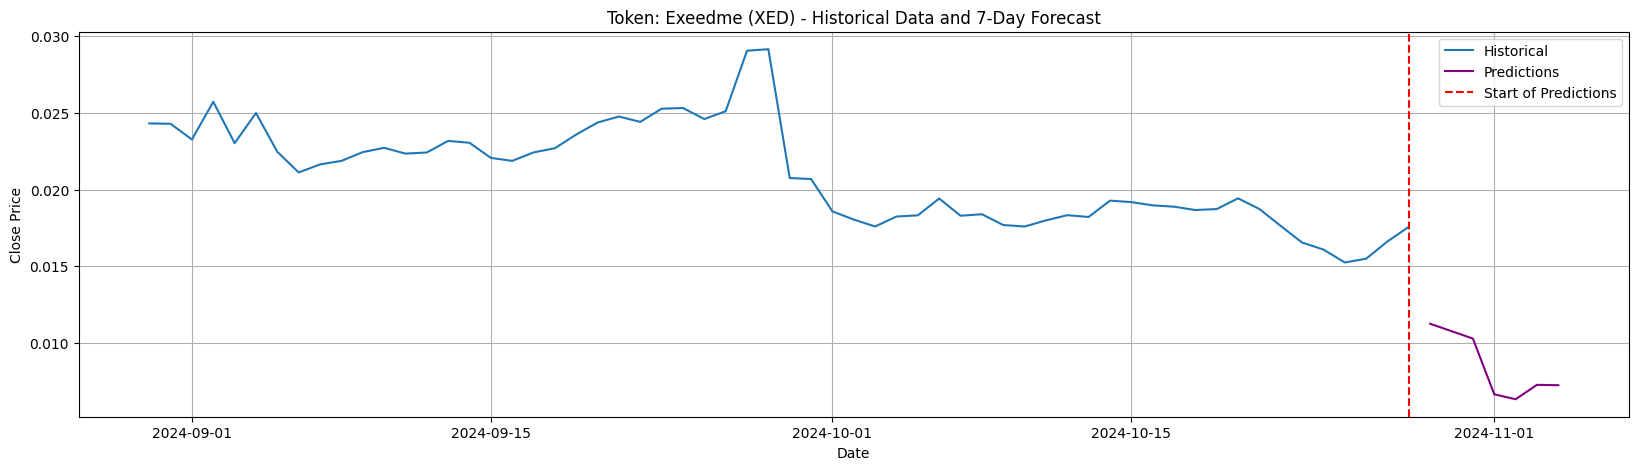

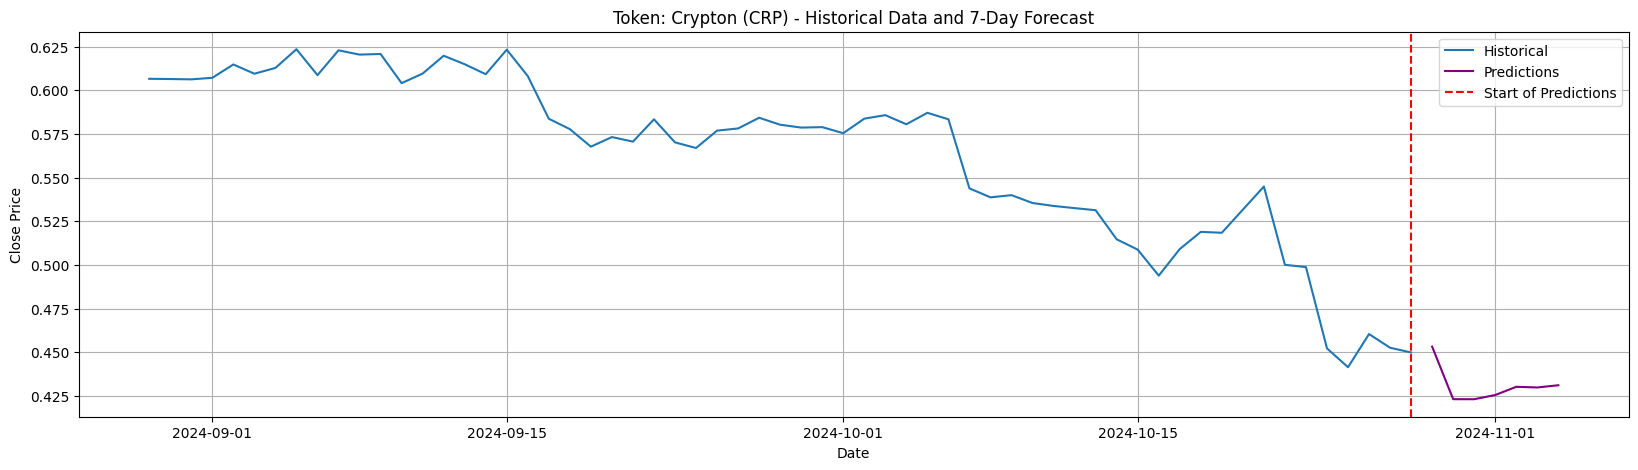

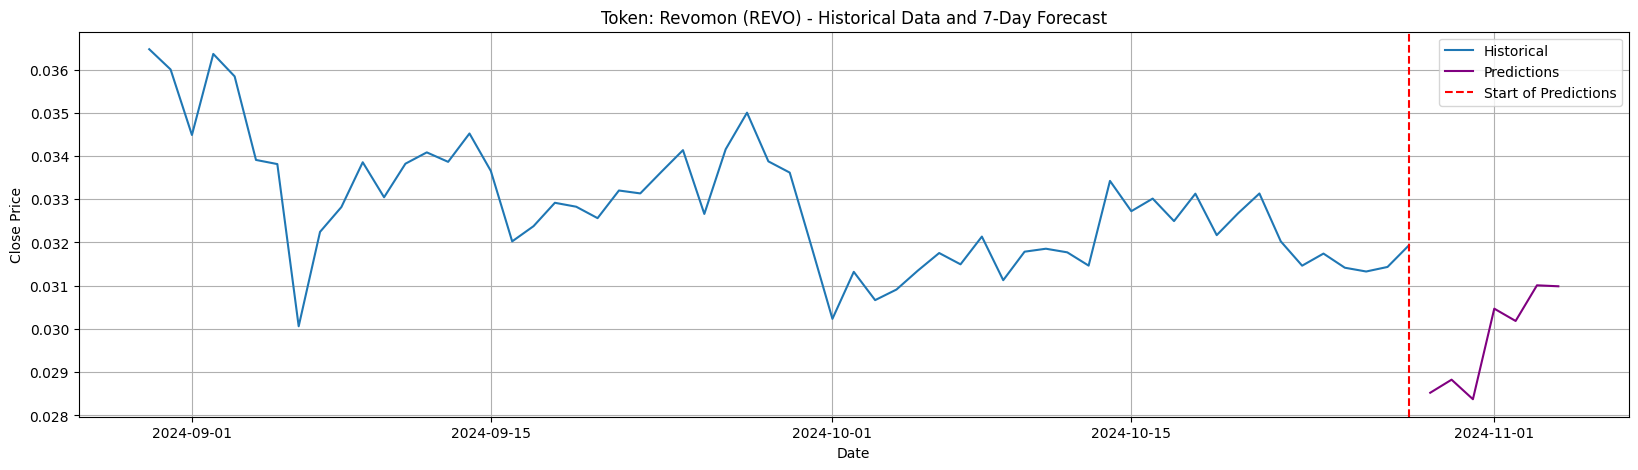

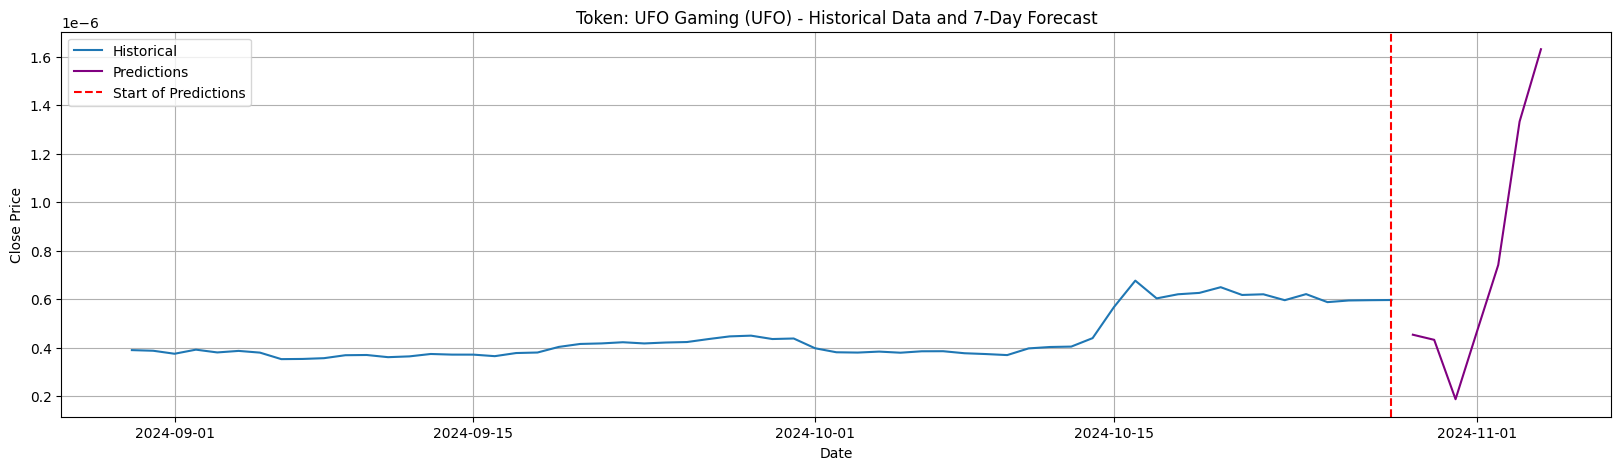

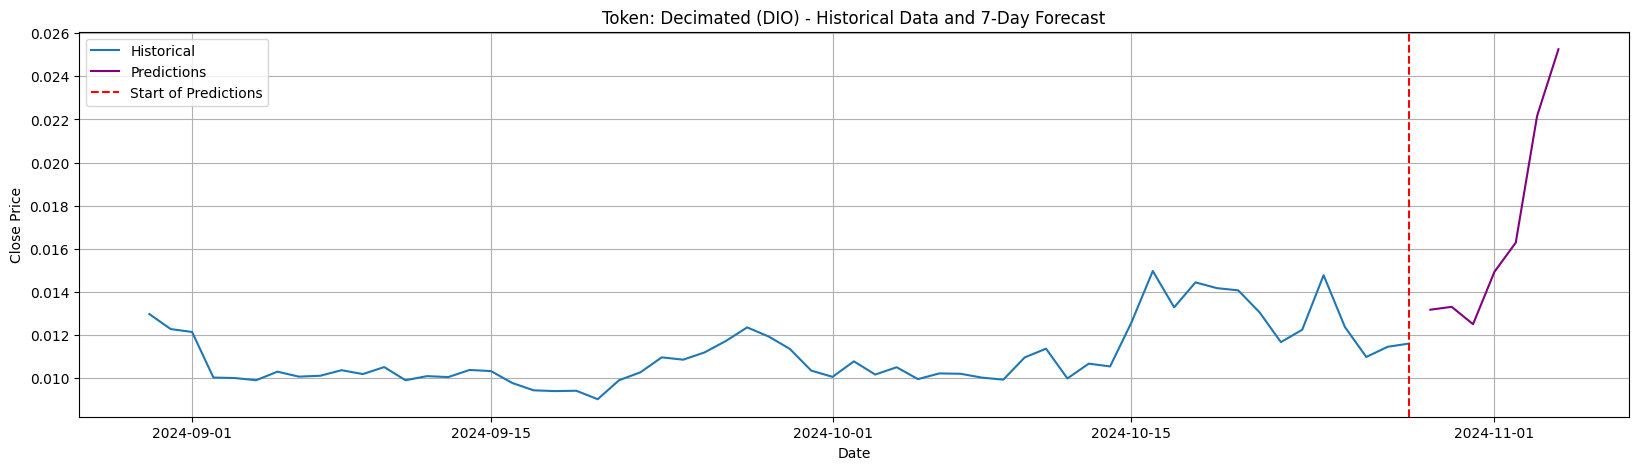

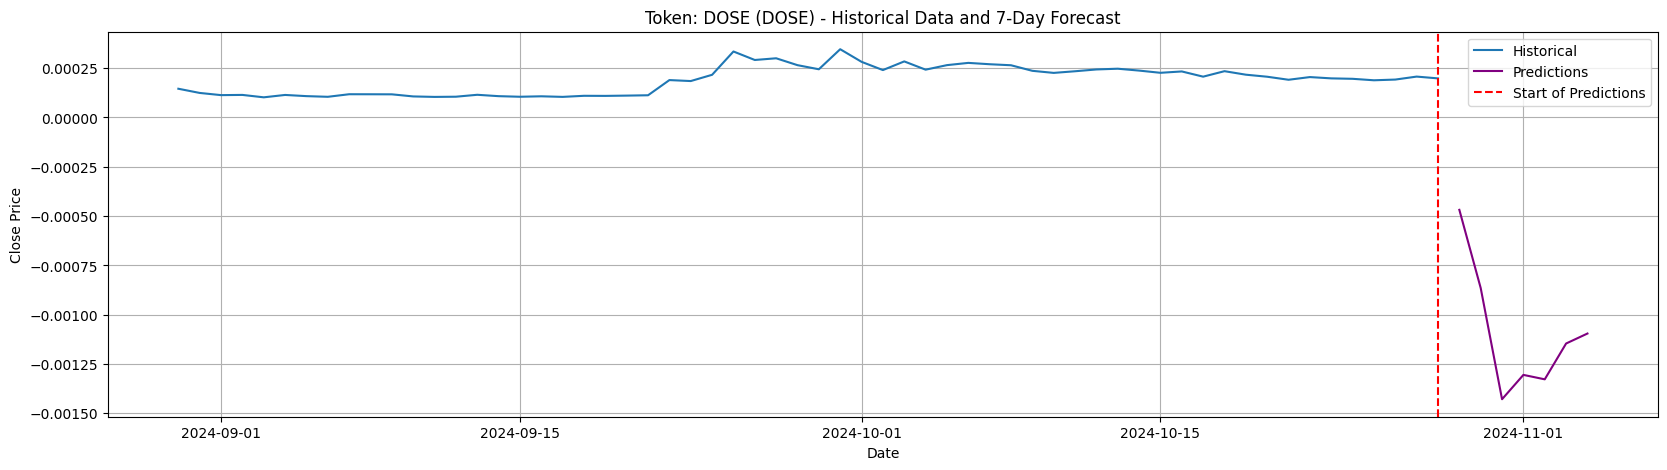

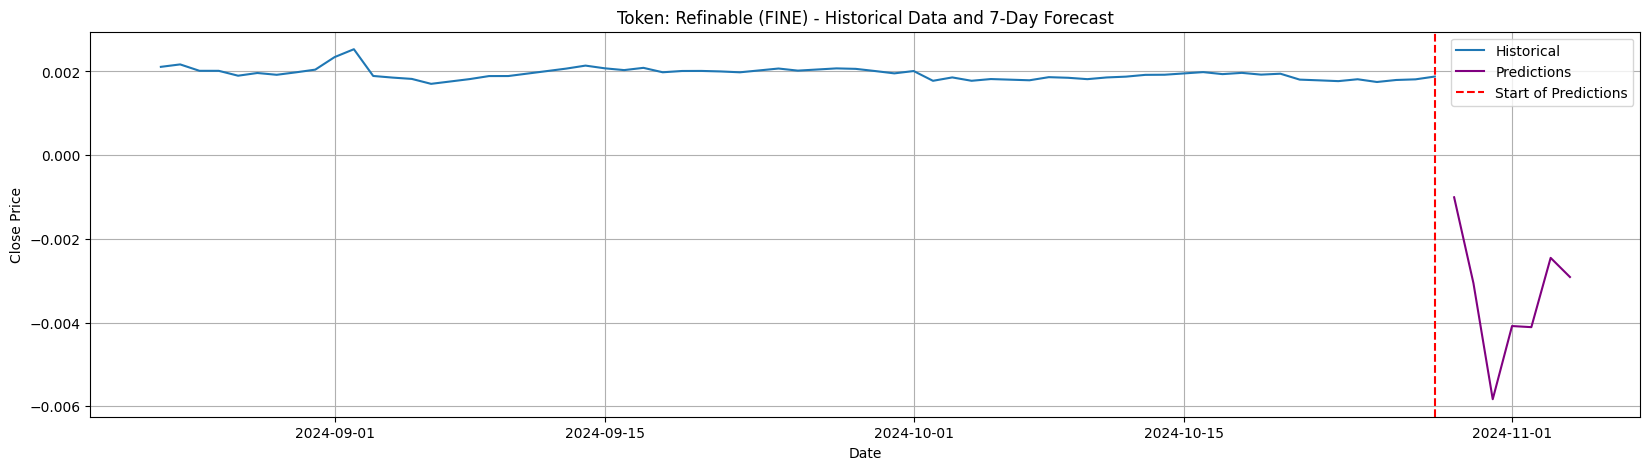

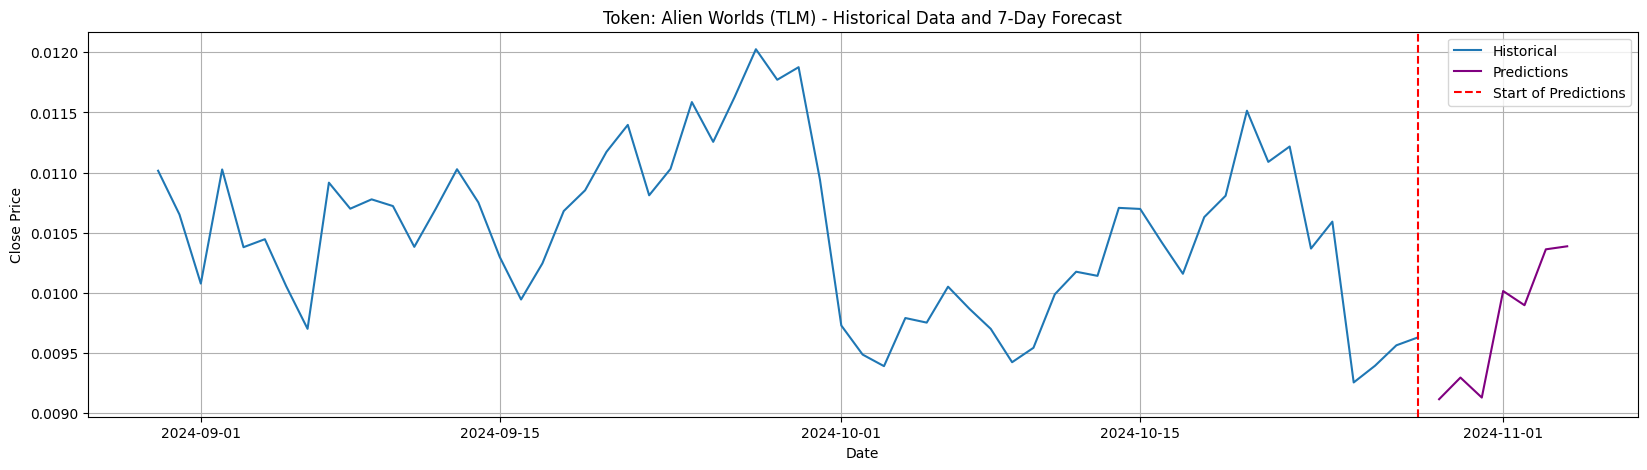

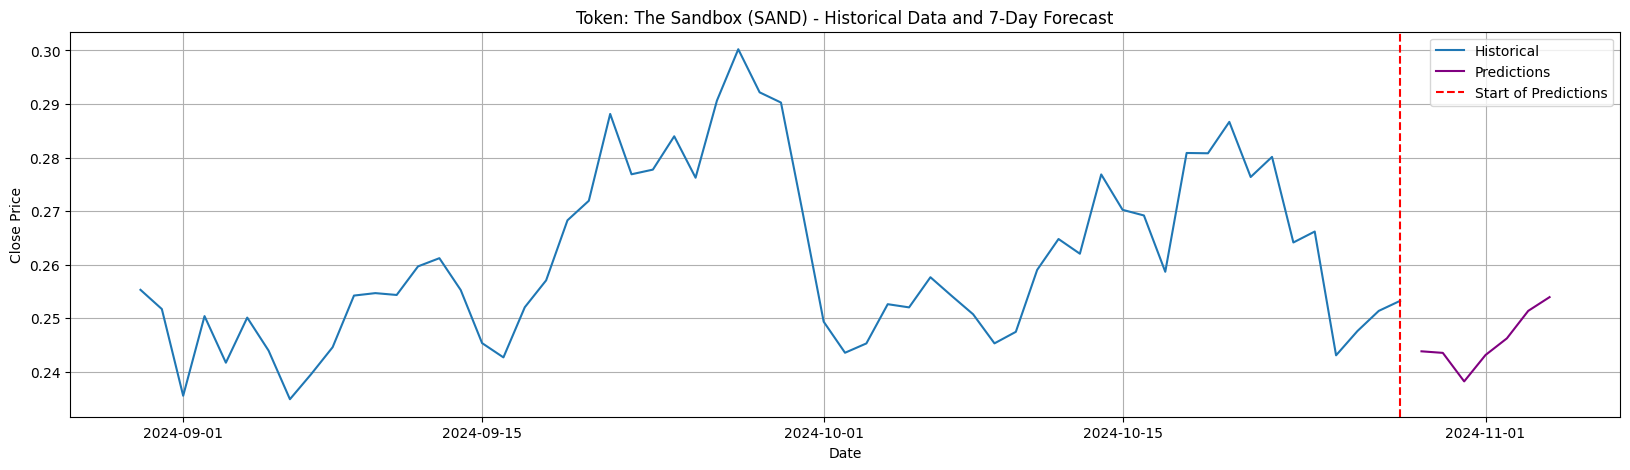

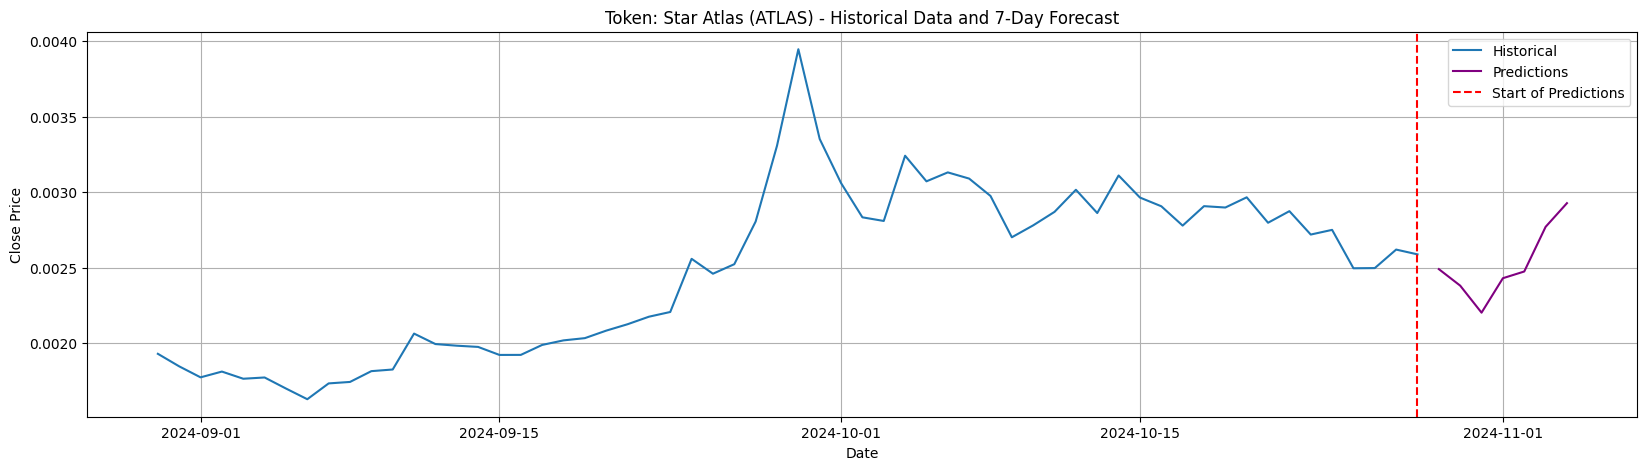

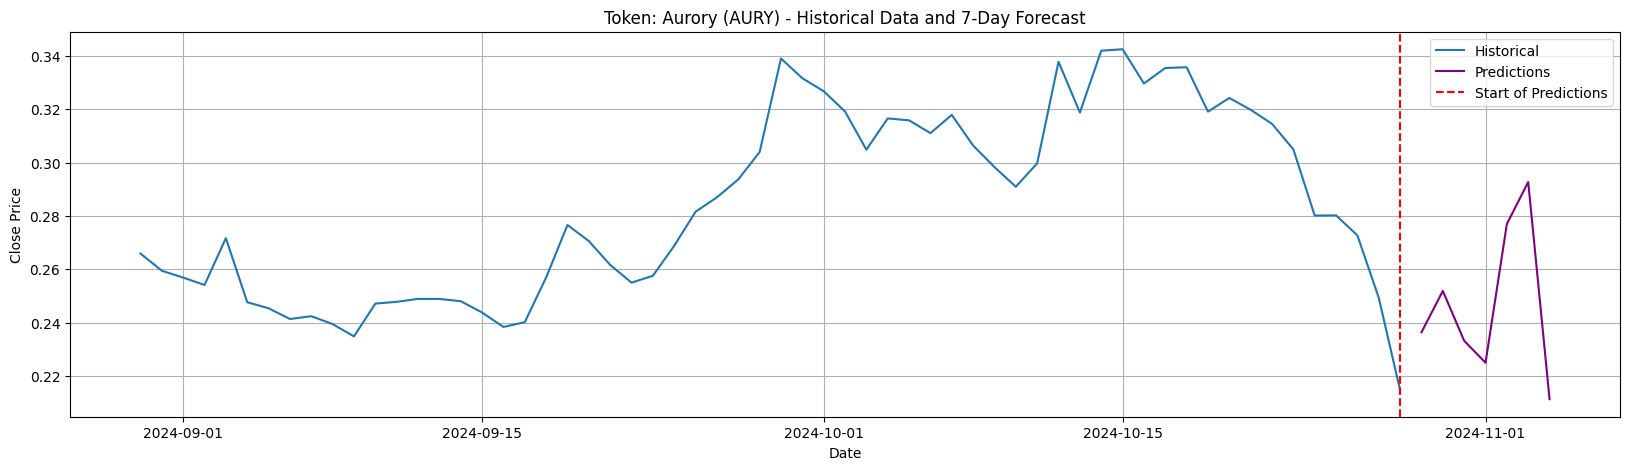

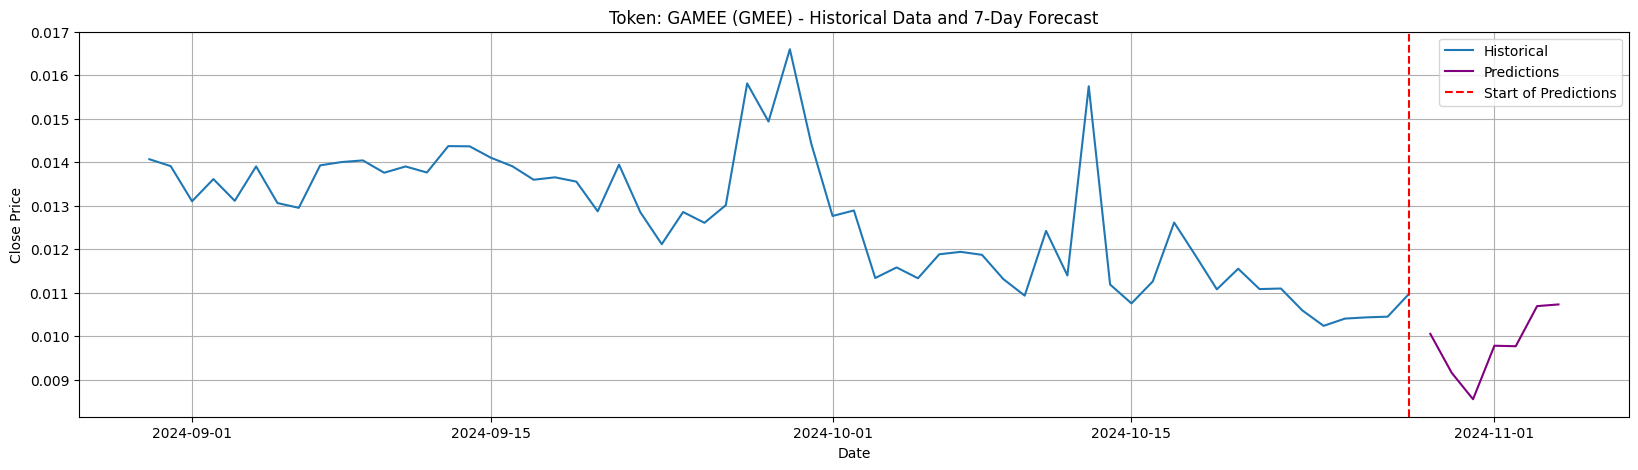

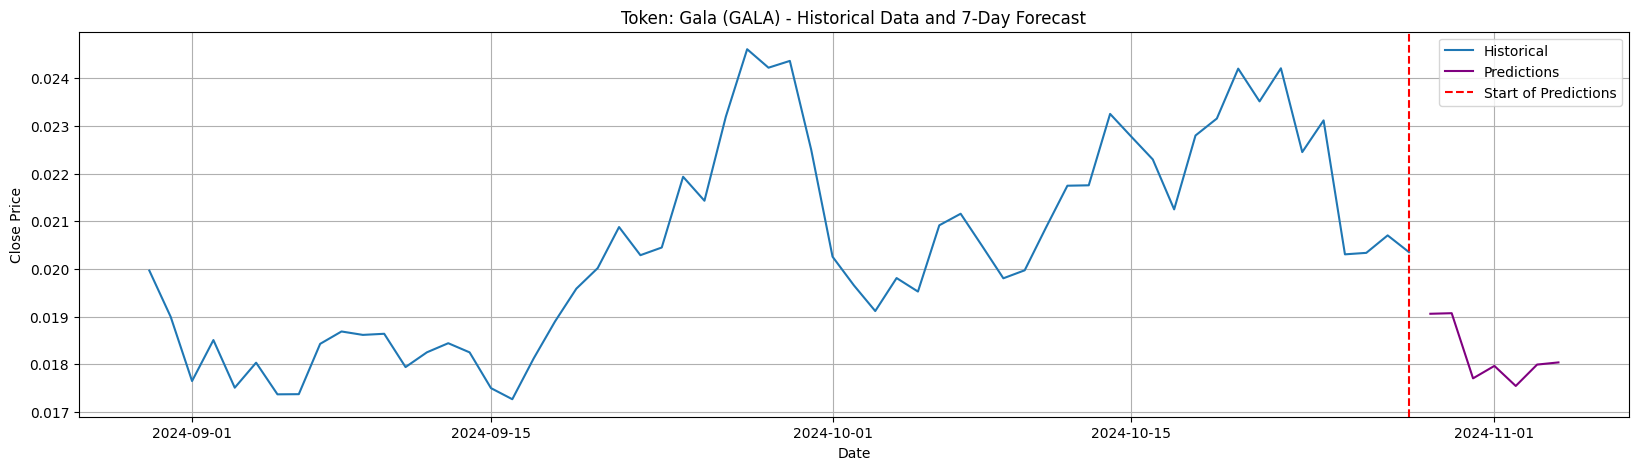

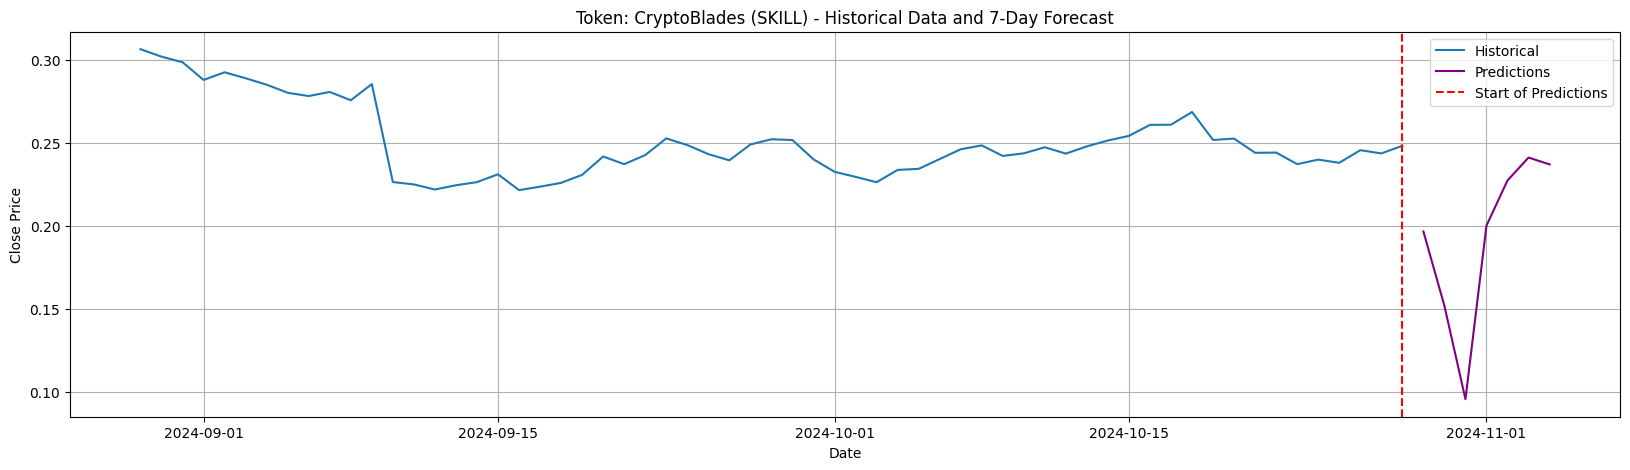

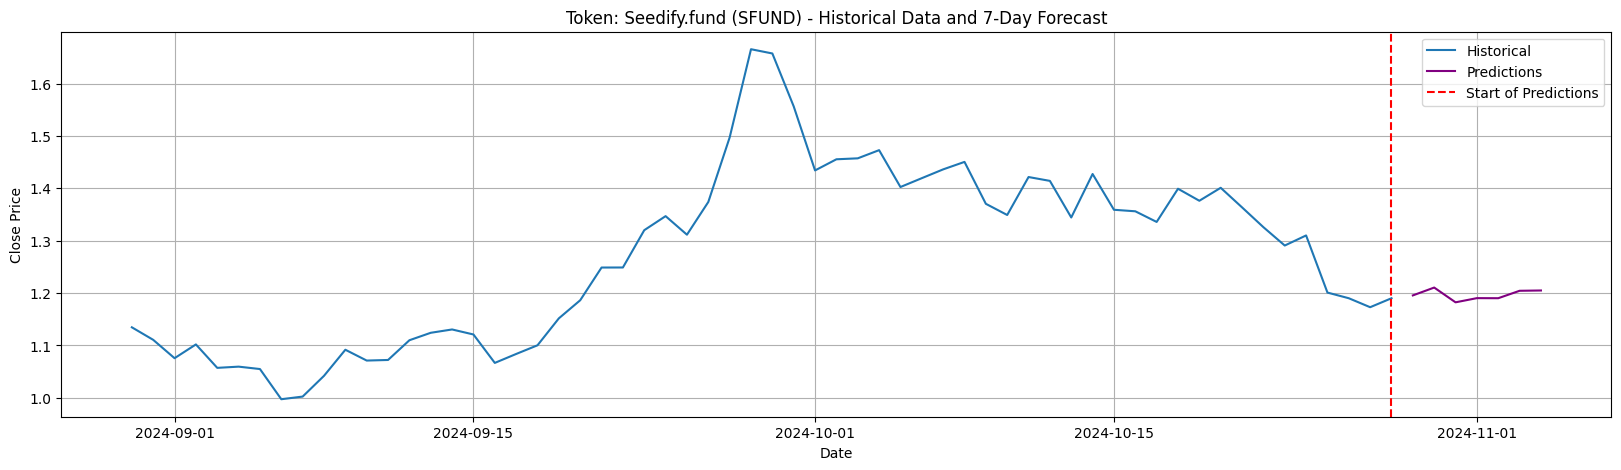

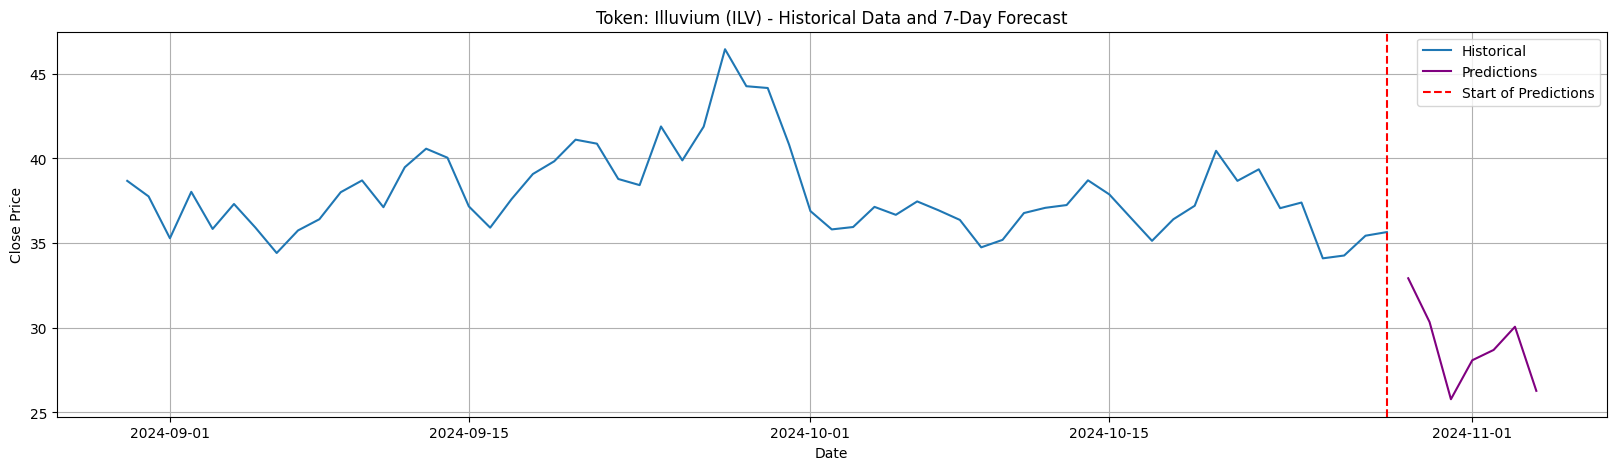

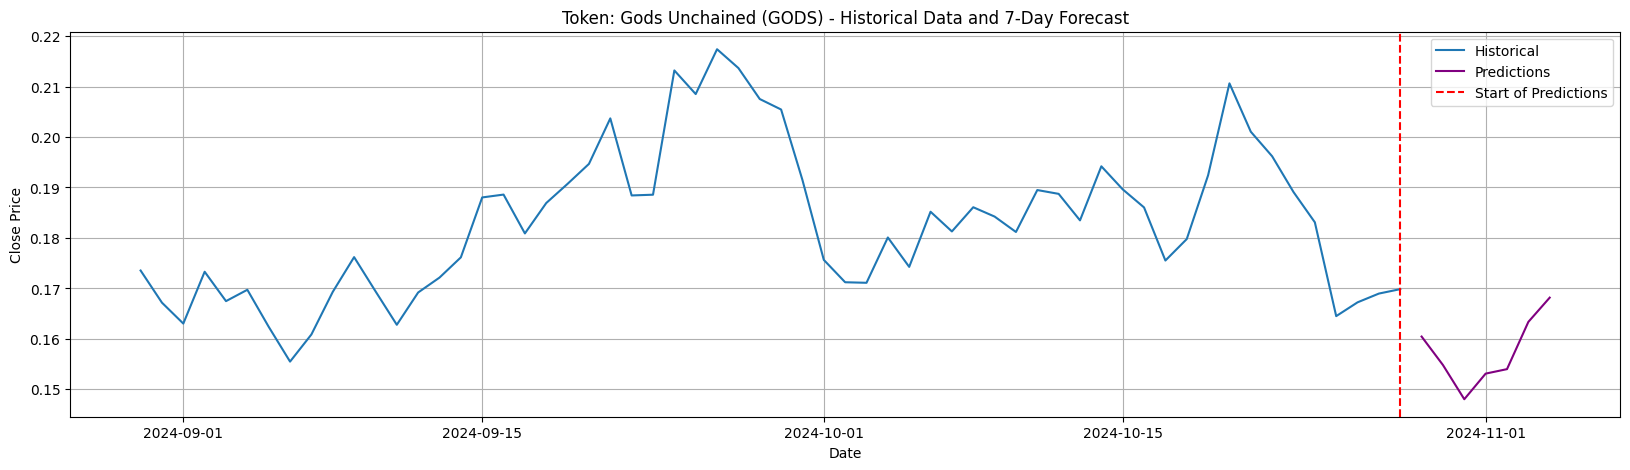

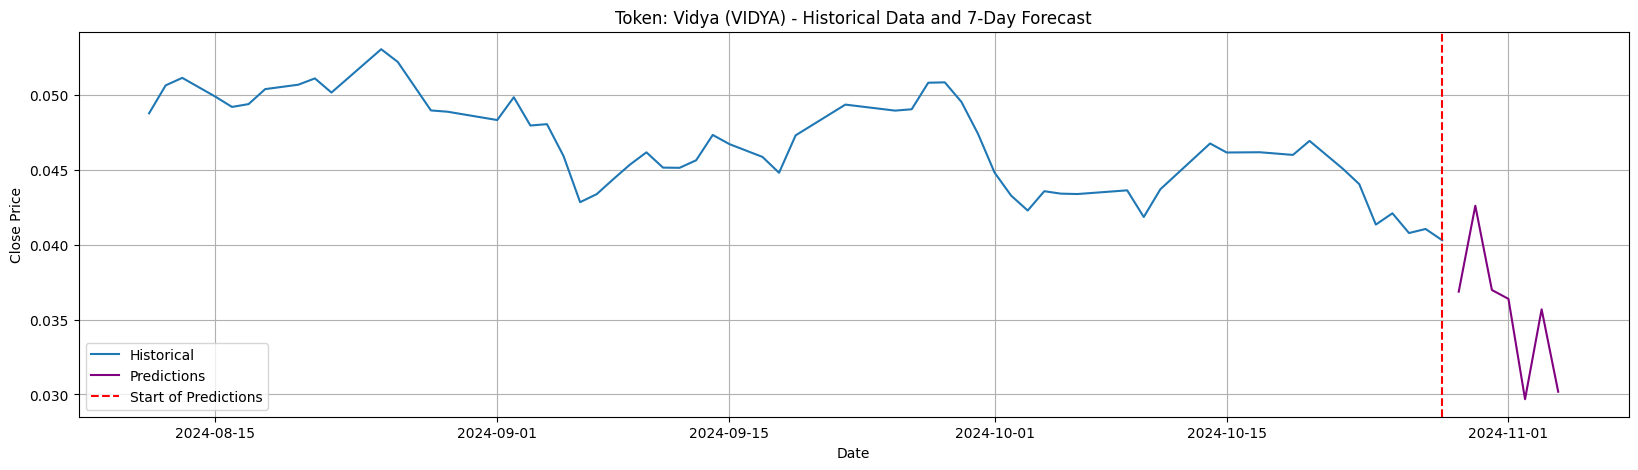

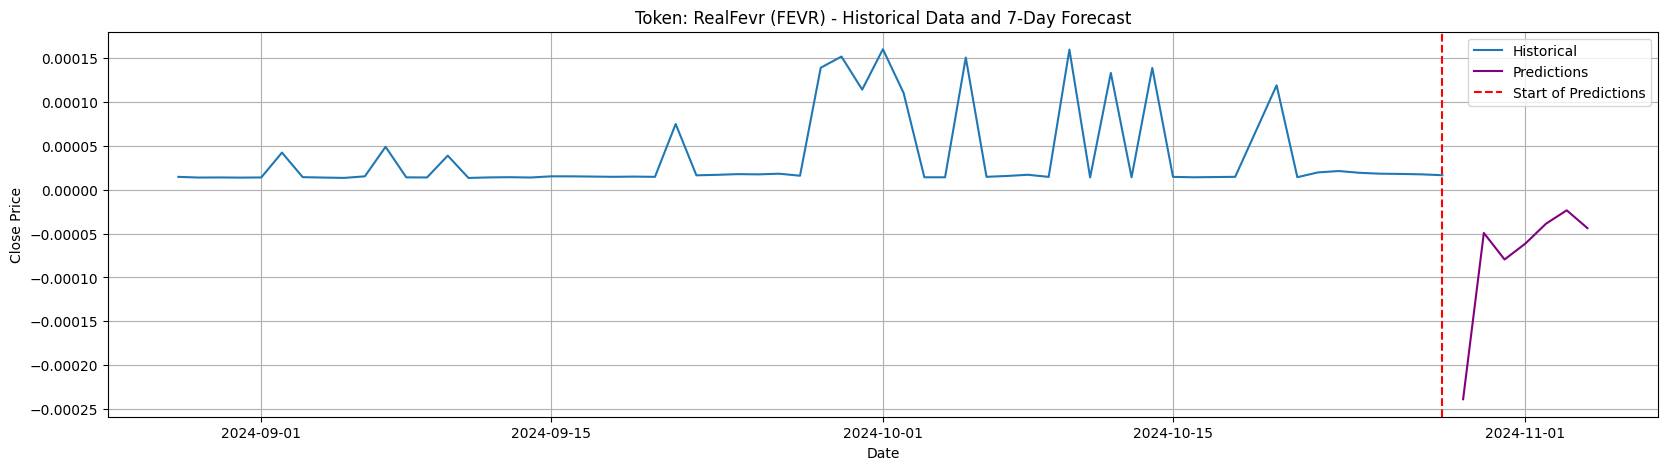

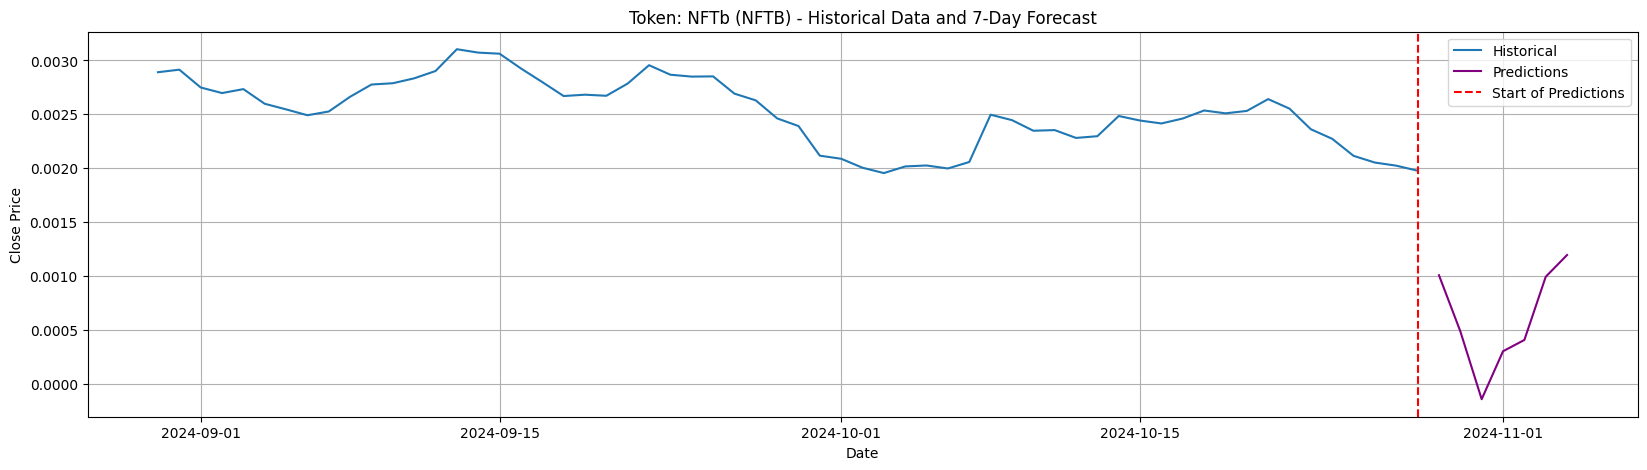

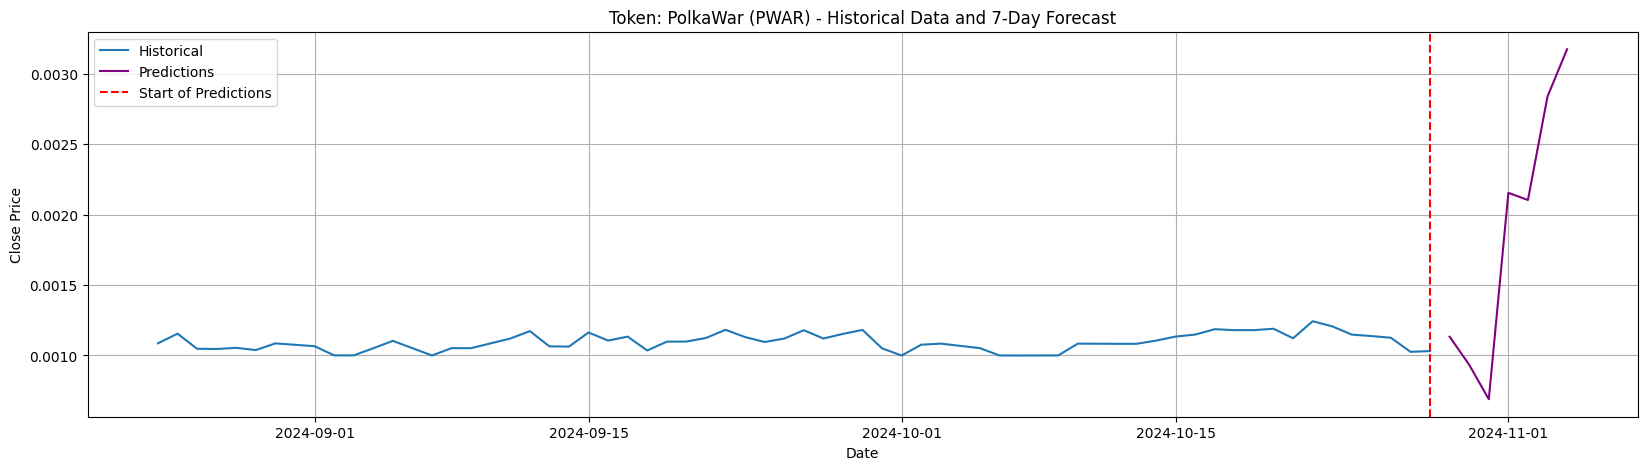

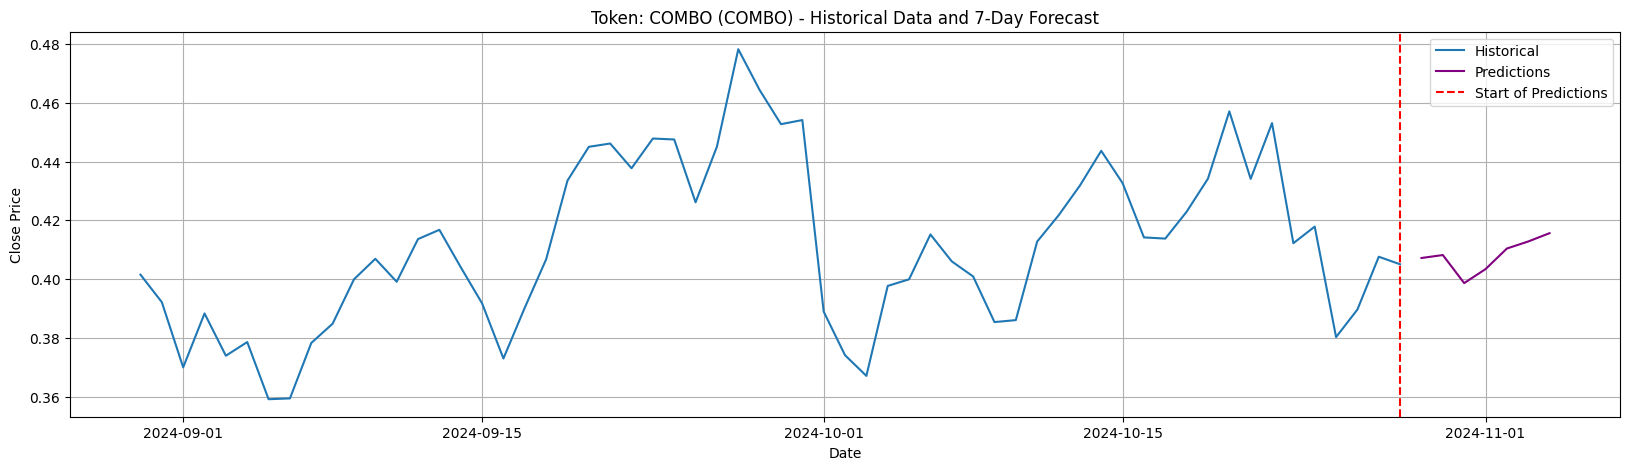

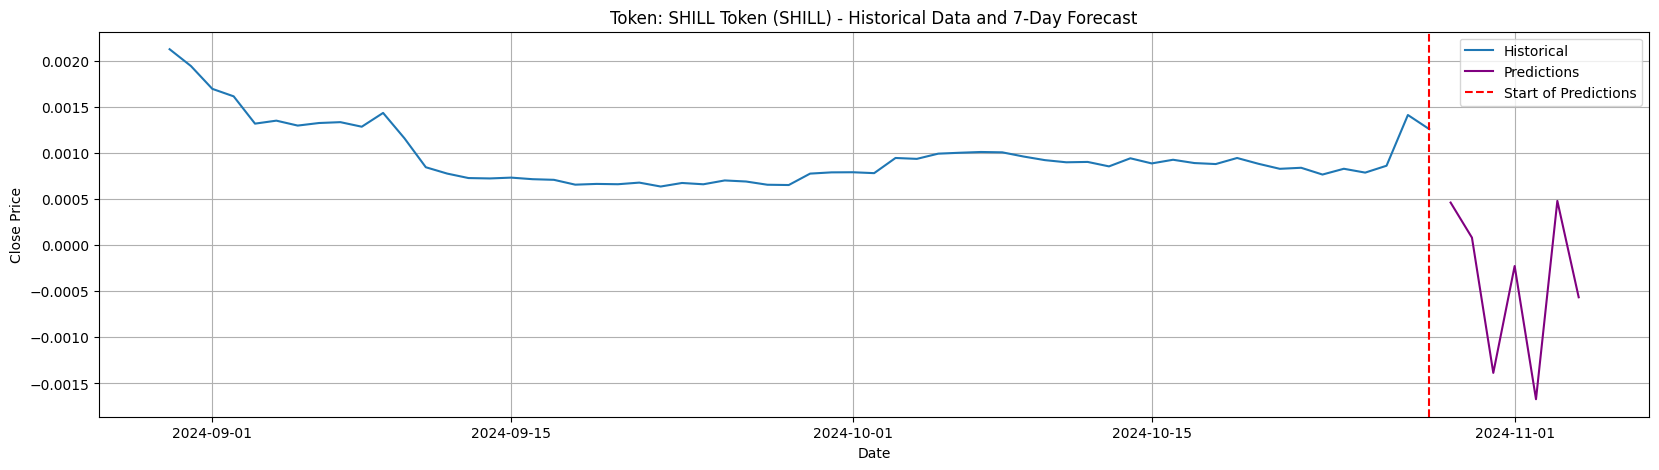

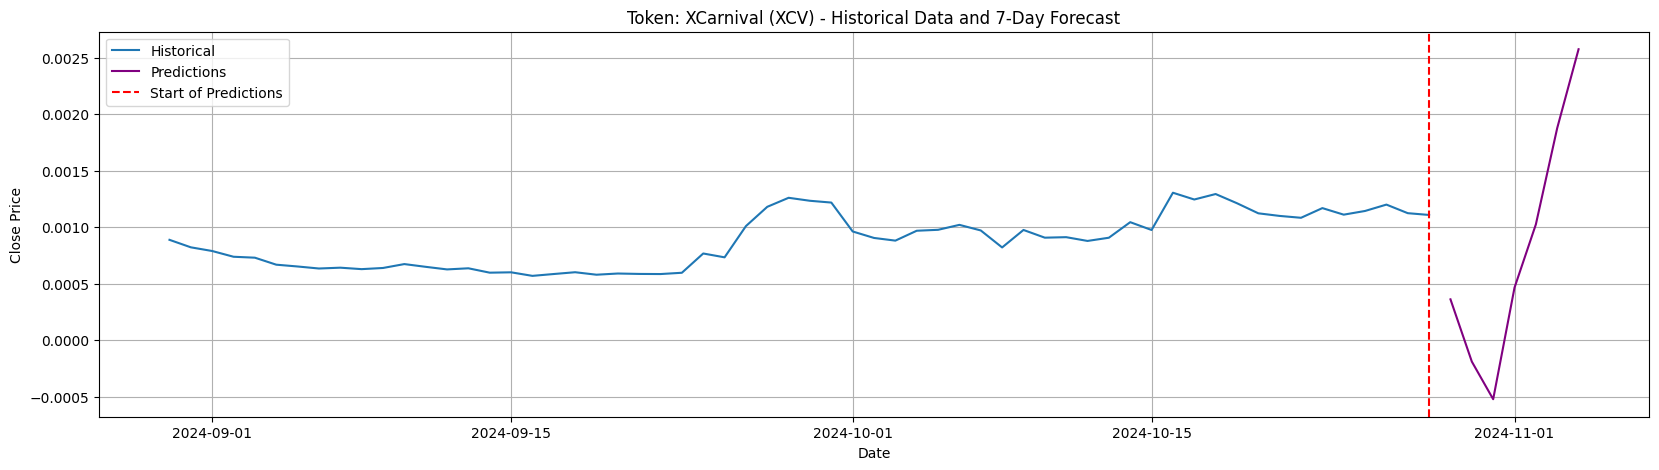

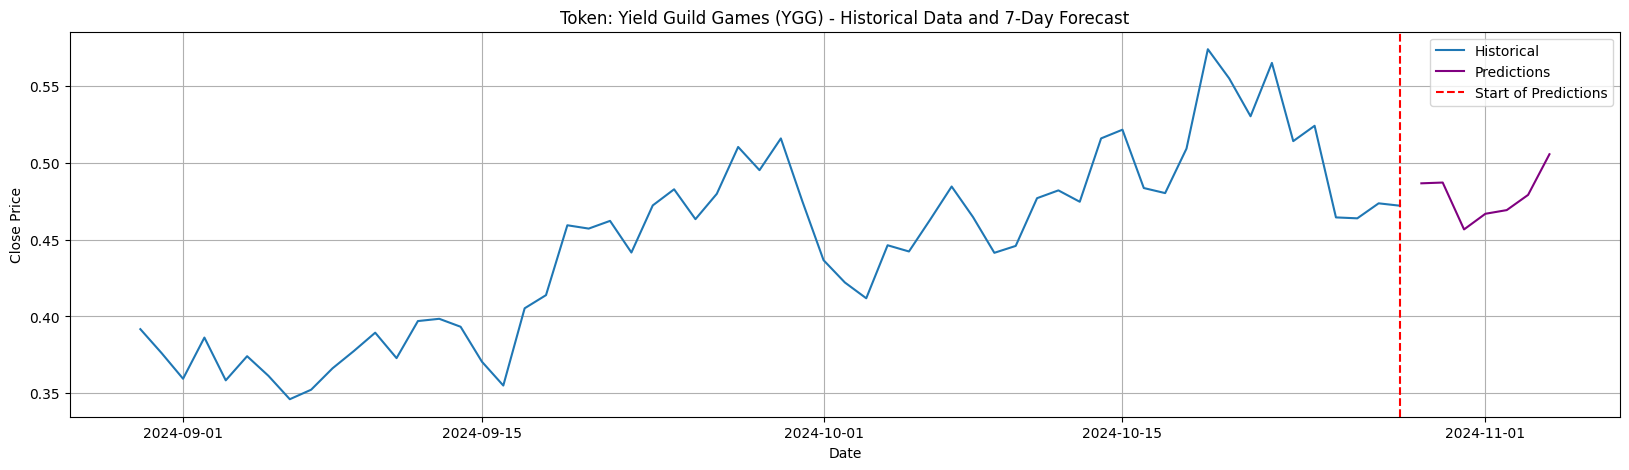

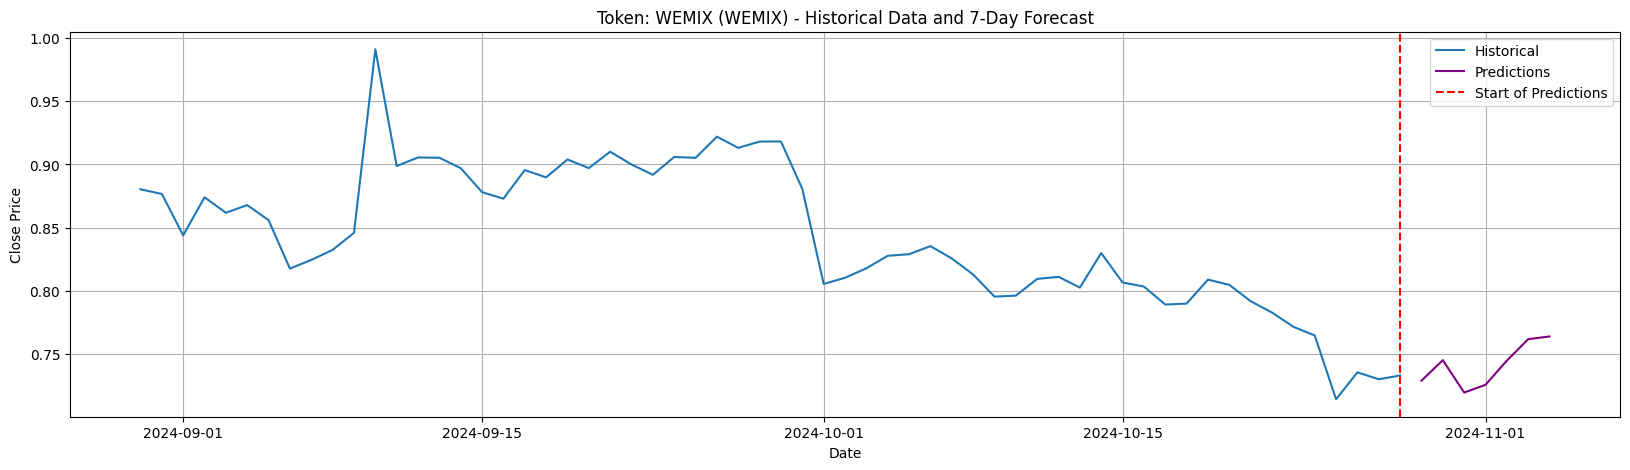

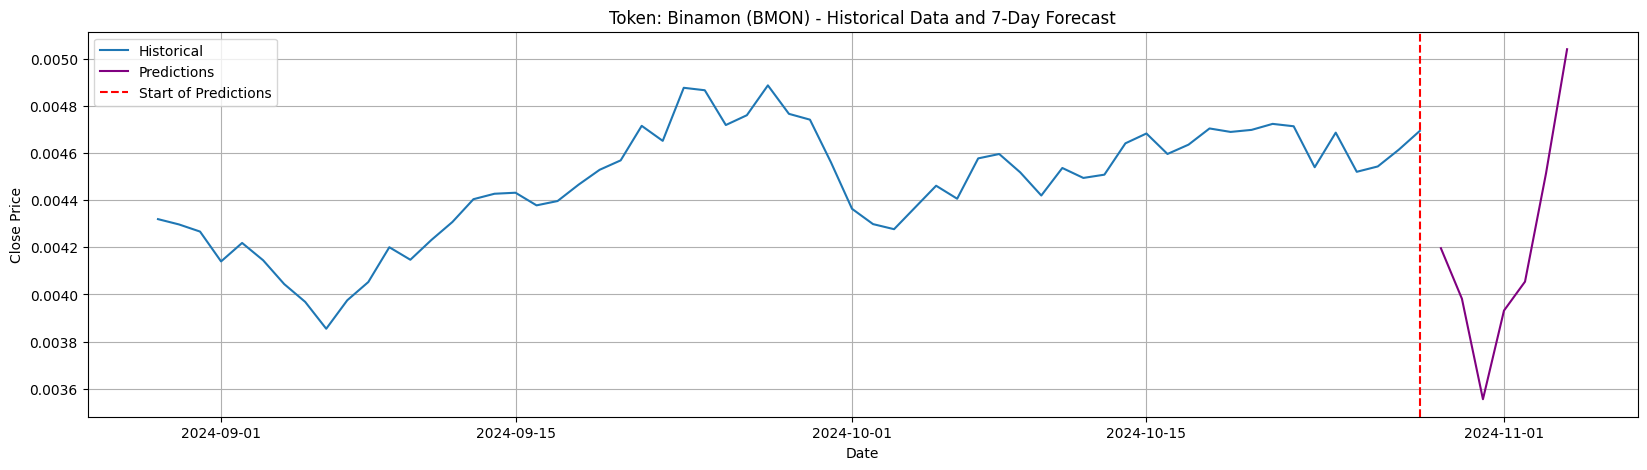

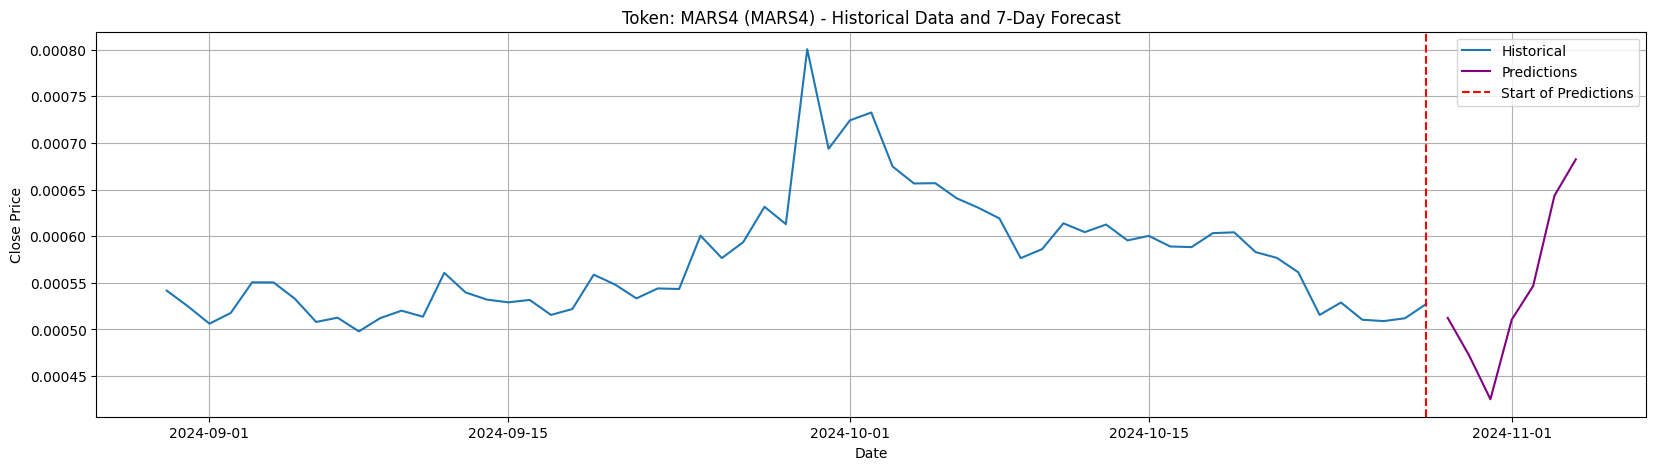

In [14]:
u.plot_predictions_only(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, last_data_points=60)